# Monte-Carlo Inverse Compton Tutorial

Basic Python tutorial on Monte-Carlo methods to model inverse Compton scattering. Written by Sebastian Heinz, University of Wisconsin-Madison

# Table of Contents:<a id="TOC"></a>

1. <a href="#Introduction">Introduction</a>
    1. <a href="#setup">Problem Setup</a>
    2. <a href="#caveats">Caveats and Simplifying Assumptions (Otherwise Known as Terms & Conditions)</a>
    3. <a href="#learninggoals">Learning Goals</a>
    4. <a href="#todo">To Do</a>
    5. <a href="#intro">Let's Do Introductions</a>
    6. <a href="#comptony">Warmup: Write a Function that Calculates the Compton-y Parameter</a>
2. <a href="#toolbox">Toolbox: Physics Modules to Build an ICMC Code</a>
    1. <a href="#seeds">Drawing Photons from a Seed Population</a>
    2. <a href="#singlescatter">Determining Whether and Where Photons Scatter</a>
    3. <a href="#electrons">Drawing Electron Velocities from a Distribution</a>
    4. <a href="#Lorentz">Lorentz Transforms</a>
    5. <a href="#thomson">Thomson Scattering</a>
    8. <a href="#inversecompton">The Magic of Inverse Compton Scattering</a>
3. <a href="#MC">Are You Ready to Monte-Carlo?</a>
    1. <a href="#mc_code">The Monte-Carlo Code</a>
    2. <a href="#plot">A Wrapper to Run and Plot Simulations</a>
4. <a href="#execute">Tutotial: Exploration of Your MC Code</a>
    1. <a href="#exploring_tau">Exploring Optical Depth</a>
    2. <a href="#trials">Exploring the Number of Trials</a>
    3. <a href="#exploring_v">Exploring Electron Velocities (Temperatures)</a>
    4. <a href="#test">Test Problem</a>
5. <a href="#next">Next Steps</a>
    1. <a href="#Maxwellian">A Maxwellian Velocity Distribution</a>
    2. <a href="#Planck">A Planck Seed-Photon Distribution</a>
    3. <a href="#reflection">Disk Reflection</a>
    4. <a href="#patchy">Covering Fraction</a>
6. <a href="#wrapup">That's It--Thanks for Playing</a>
7. <a href="#appendix1">Solutions</a>
8. <a href="#appendix2">Raw Code</a>

# 1. Introduction<a id="Introduction"></a> <a href="#TOC">(Back to TOC)</a>

In this tutorial we will explore the nature of inverse Compton scattering. Inverse Compton scattering is crucial to understanding the high-energy spectra of astrophysical sources like accretion disks. Consider the spectrum of the famout X-ray binary Cygnus X-1, a black hole accreting mass from it's O-star companion from <a href="https://ui.adsabs.harvard.edu/abs/1999MNRAS.309..496G/abstract">Gierlinski et al. 1999</a><a id="Fig1"></a>:

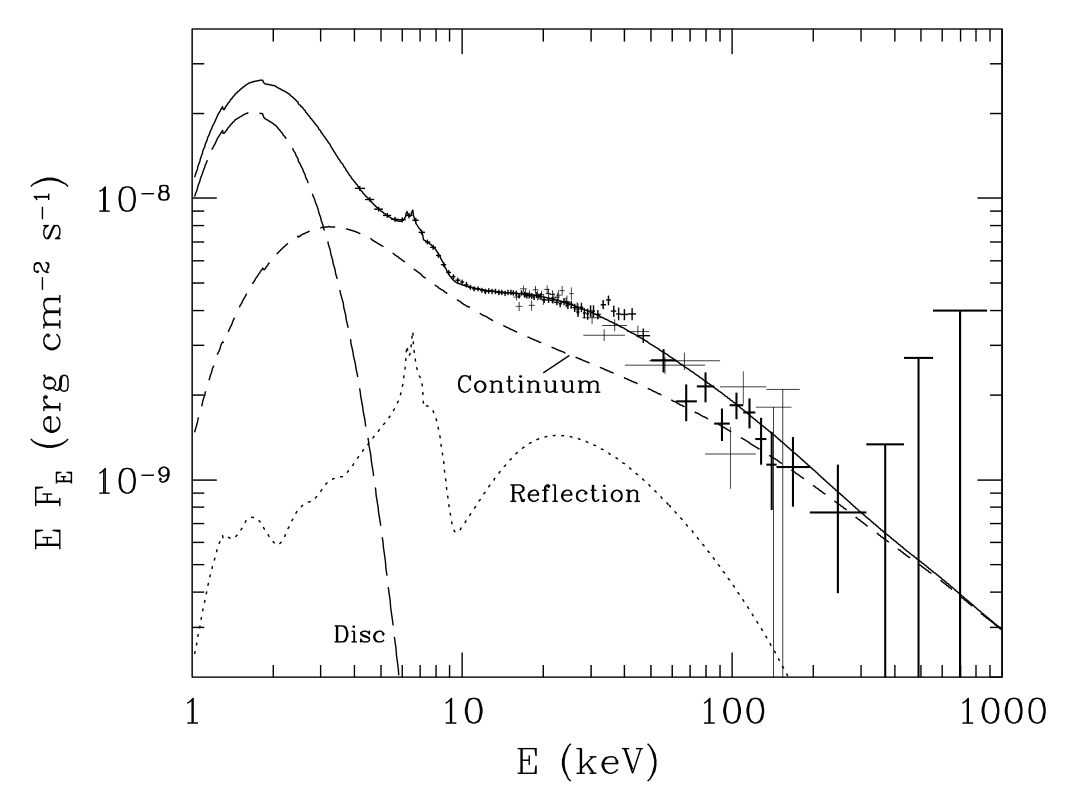

In this so-called soft state, the majority of the emission at energies above 2 keV is due to that spectral component labeled "continuum" in the figure. This "continuum" is produced by a layer of hot gas hovering above the accretion disk in this system, like the solar corona sits above the Sun's photosphere. The electrons in this corona of hot, ionized gas Compton-upscatters the disk photons (in the figure above, the disk produces the long-dashed component at lower energies). Our goal here is to investigate just that process works.

Going through this tutorial will require some physics concepts and some programming and statistics concepts. The physic we need is
1. free electron scattering of photons in the the electron's rest frame, which we will approximate as Thomson scattering, with a basic understanding of radiative transfer
2. Lorentz transforms from the observer's frame to the electron's frame and back, which itself requires a bit of relativity: The definition and nature of four-vector (in particular: four-momenta and four-velocities). The basics are outlined in <a href="#Lorentz">the next section</a>.

The programming and statistics concept needed is the application of Monte Carlo techniques. Monte Carlo simulations solve equations statistically by simulating a large number of individual particle trajectories and events (in this case we are following photon trajectories), each called a trial. In terms of programming, this requires the use of a random number generator and then keeping track of the observables we are interested in. In terms of statistics, the particles are injected one by one with properties drawn from the probability distribution of the particles (for example, the energies of a thermal distribution of particles would be drawn from a Maxwell-Boltzmann distribution).

Thus, the real work in creating a Monte Carlo simulation is in formulating the probability density function (PDF, also calle the distribution function in statistical mechanics) for our particles. As you will see, we will need to integrate the PDF to derive the __cumulative__ probability density function and then __invert__ it. Sometimes this is easy (as in the simplified example of this tutorial we are going through in class), sometimes this is hard (like in the case of the optional homework project on implementing a Planck function for the proper input distribution function of photons).

__Note:__ There is a lot of commentary here, but not that much actual code. The raw code is liste in <a href="#appendix2">Appendix 2</a> so you can see the basic structure.

## 1.1 Problem Setup<a id="setup"></a> <a href="#TOC">(Back to TOC)</a>

Consider an ionized, hot slab of gas (the corona) of temperature $T_{\rm corona}$ with some finite thickness $L$, located above an optically thick source of blackbody photons (the disk) with temperature $T_{\rm BB} \ll T_{\rm corona}$. The slab contains free electrons at density $n$ that can scatter the radiation.

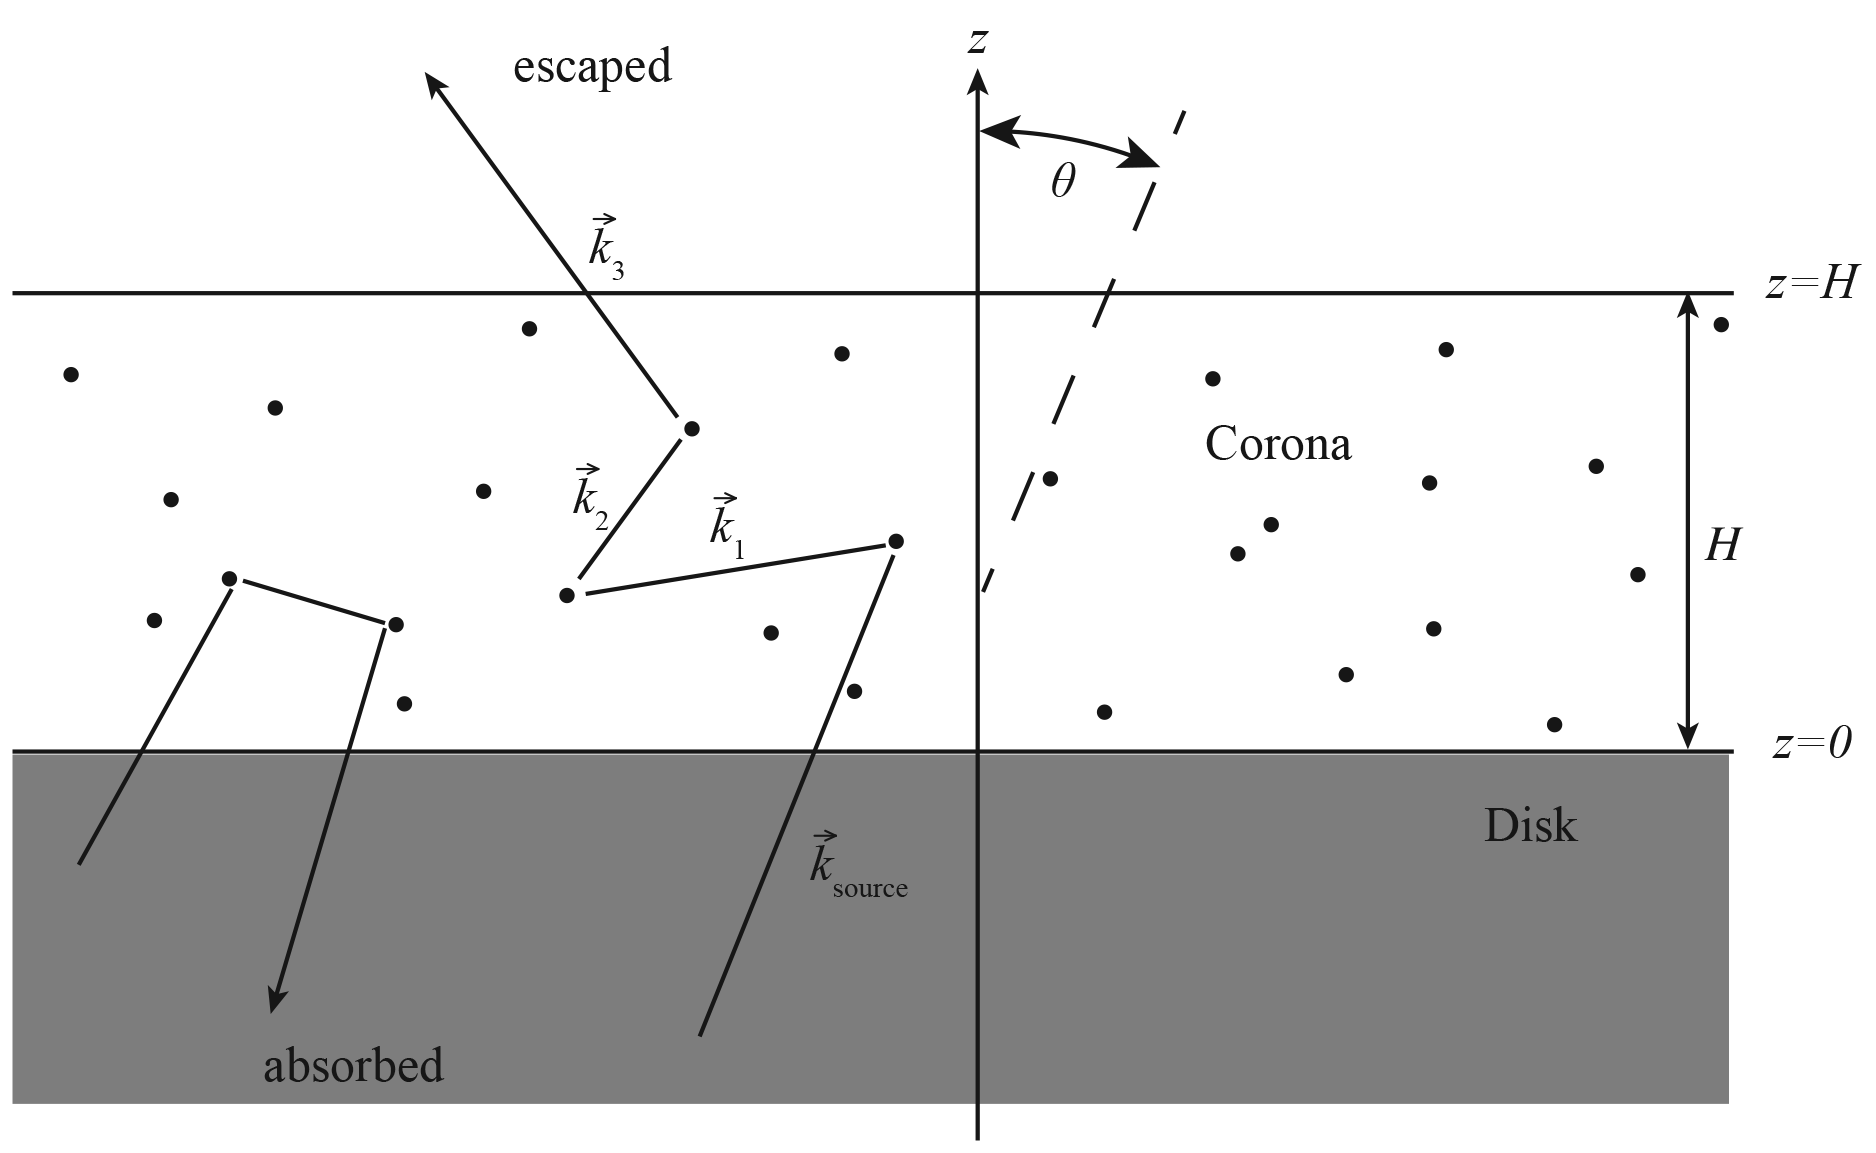

Following the sketch, set up your coordinate system with the corona above the disk in the $z$-direction and measure angles from the $z$-axis as $\mu =\cos{(\theta)}$.

Photons enter the slab from below with an isotropic distribution of angles $0 < \mu \leq 1$ and can exit the corona at the top surface. Downgoing photons are re-absorbed by the disk.

We will store the basic Monte-Carlo simulation parameters in a dictionary called `mc_parms`, which will contain
* `'N_photons'`: The number of photons we want our Monte-Carlo simulation to track
* `'kt_seeds'`: The initial energy of the photons (or Planck spectrum temperature)
* `'H'`: The height of the corona (in cm)
* `'velocity'`: The thermal speed of the electrons (used only for mono-energetic distribtion)
* `'kt_electron'`: The temperature of the electrons (in energy units, used by Maxwellian) 
* `'tau'`: The vertical thomson optical depth of the corona ($\tau=n\sigma_{\rm T}H$)
* `'v_dist'`: The name of a function that returns a random electron velocity, drawn from the velocity distribution
* `'hnu_dist'`: The name of a function that returns random seed photon luminosities, drawn from the photon distribution

__Note__: We use __CGS__ units throughout.

## 1.2 Caveats and Simplifying Assumptions (Otherwise Known as Terms & Conditions)<a id="caveats"></a> <a href="#TOC">(Back to TOC)</a>

* We will make the simplifying assumption that the disk and corona are extended to infinity in the $x$ and $y$-directions so that our problem is symmetric about the $z$-axis. We measure optical depth as $d\tau=n\sigma_{\rm T}ds$ along the photon trajectory.
* We will neglect the non-linear effects of Compton cooling on the temperature of the corona or heating of the disk (that is, assume that both maintain a fixed temperature).
* We will neglect the Compton scattering recoil and treat scattering as elastic (that is, it doesn't change the energy of the photon).
* We will neglect the relativistic (Klein-Nichina) corrections to the scattering cross section of high-energy photons. This is OK to lowest order, but will be important once the photons reach energies comparable to the electron rest mass _energy in the electron frame_.
* We will initially simplify to mono-energetic seed photons and coronal electrons, but will fix that later.
* We are also going to a simple, brute-force approach to Monte-Carlo. There are ways to be much more clever about how to generate trials so that the signal-to-noise of our simulation becomes more even. But that is for another day. 

Use at your own risk. You are encouraged to expand the code on your own to relieve some of these simplifications.

## 1.3 Learning Goals<a id="learninggoals"></a> <a href="#TOC">(Back to TOC)</a>

In this tutorial, we hope you will gain insight and experience about the following concepts:
* The physics of inverse Compton scattering
* The basics of Monte Carlo techniques
* The basics of radiative transfer

## 1.4 To Do<a id="todo"></a> <a href="#TOC">(Back to TOC)</a>

The two main tasks are
* to assemble the physics modules we provide into a function that performs all the steps of inverse Compton scattering
* to use your code to explore the physics of inverse Compton scattering

We have added some additional tasks to explore some interesting/important programming concepts that relate to Monte-Carlo techniques and to comptonization. Do these first. They are embedded in different parts of this tutorial, with links below.
1. First, write a routine `compton_y()` to <a href="#comptony">determine the Comton-y parameter</a> from a set of seed photons and scattered photons.
2. Complete the code in function `random_direction()` in section <a href="#MCstart">To Do: Drawing a Unit Vector From an Isotropic Distribution</a>
3. Complete the function `tau_of_p()` in section <a href="#singlescatter">How Far Does the Photon Travel Before Scattering?</a>
4. Test the Lorentz transform code in section <a href="#Lorentz">Lorentz Transforms</a>
5. Use your exploration of `lorentz_transform()` to determine the maximum energy gain of a photon by single inverse-Compton scattering in section <a href="#inversecompton">The Magic of Inverse Compton Scattering</a>

Once you are done with those, your Monte-Carlo code will be complete and you will start exploring the physics of inverse Compton scattering in the tutorial sections <a href="#MC">Are You Ready to Monte-Carlo?</a> trough <a href="#Planck">A Planck Seed Photon Distribution</a>


## 1.5 Let's Do Introductions<a id="intro"></a> <a href="#TOC">(Back to TOC)</a>

We'll do some important paperwork by importing packages we need and by defining some physical constants etc.

In [1]:
#
# Let's start with loading the usual packages
#
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.integrate as integrate
from scipy.integrate import quad

#
# Some useful definitions
#
c_light=3.e10              # speed of light--always useful       
m_electron=9.10938356e-28  # electron mass
sigma_t=6.65e-25           # Thomson cross section
figure_counter=0           # keeps track of how many figures we've saved
#
# Let's define our dictionary now so we can adjust individual parameters later
#
def f_of_v_mono():                    # we will define this later
    return(0)
def f_of_hnu_mono():                  # we will define this later
    return(0)

mc_parms={'n_photons':100000,         # number of trials--start somewhat small and go up
          'kt_seeds':1.6e-9,          # temperature/energy of the seed photons (in energy units)
          'H':3e7,                    # height of the corona (H ~ R, and R ~ 100 R_g ~ 3e7 cm)
          'velocity':3e9,             # electron velo|city (only used by mono-energetic distribution)
          'kt_electron':3.2e-8,       # electron temperature (in energy units, used by Maxwellian)
          'tau':0.1,                  # optical depth of the corona
          'v_dist':f_of_v_mono,      # name of velocity distribution function (start with delta function)
          'hnu_dist':f_of_hnu_mono,  # name of photon distribution function (start with delta function)
         }

## 1.6 Warmup: Write a Function that Calculates the Compton-y Parameter<a id="comptony"></a> <a href="#TOC">(Back to TOC)</a>

In astrophysics, we are often confronten with multiple competing effects/terms in equations. Viscosity and turbulence (where microscopic and macoscopic terms in the momentum equation compete), photo- vs. collisional ionization, magnetic vs. gas pressure are some examples. We will want to have a simple way to estimate the strenght/importance of some effect. In inverse Compton scattering, the most commonly used way to determine whether inverse Compton scattering is important is the Compton-y parameter. It is defined as the average energy gain a photon will experience through its interaction with electrons:

$$
    y \equiv = \langle\frac{\Delta h\nu}{h\nu}_{0}\rangle N_{\rm s} = \langle\frac{h\nu - h\nu_{0}}{h\nu_{0}}\rangle N_{\rm s}
$$

where $N_{\rm s}$ is the avenumber of scatterings a photon will experience and $\langle\Delta h\nu/h\nu_{0}\rangle$ is the average energy gain per scattering.

For thermal electrons, this will be of the order of

$$
    y_{\rm th} = \frac{4kT - h\nu_{0}}{m_{\rm e}c^2}
$$

We will be in a position actually measure $y$. Your first task is to write a function that calculates and returns the Compton-y parameter from two sets of photons: Before and after scattering. We will use this later to measure the Compton-y parameter in your simulations.

In [2]:
def compton_y(pre,post):
    return(np.mean((post-pre)/pre))

def test_compton_y():
    post=np.ones(100)*2
    pre=np.ones(100)
    print('Your code produces a y-parameter of {:5.2f}. The test value is 1.00'.format(compton_y(pre,post)))
    
test_compton_y()

Your code produces a y-parameter of  1.00. The test value is 1.00


# 2. Toolbox: Physics Modules to Build an ICMC Code <a id="toolbox"></a> <a href="#TOC">(Back to TOC)</a>

## The Life of a Photon

In this tutorial, we are providing a basic tool box of routines that you need to assemble an inverse Compton Monte Carlo code. We are somewhat following the path of the photons: We generate the seed photons and the electrons they interact with in the routines in 2.1. In 2.2, we calculate how far a photon travels before is scatters. In 2.3, we generate a random velocity for the electron the photon scatters with. In 2.4, we introduce the Lorentz transform (to transform the photons into the electron frame and back), and 2.5, we introduce Tomson scattering and generate a proprely randomized scattering angle. Then, in 2.6, we combine 2.4 and 2.5 (Lorentz transform and Thomson scattering) into a function that inverse-Compton-scatters a photon.

The routines you need to assemble your Monte Carlo code included in this section are:
* `draw_seed_photon()`
* `scattering()`
* `draw_electron_velocity()`
* `lorentz_transform()`
* `inverse_compton()`

## 2.1 Drawing Photons from a Seed Population <a id="seeds"></a><a href="#TOC">(Back to TOC)</a>

The key in Monte Carlo simulations is running lots of trials of a process and record the outcome. The parameters for these trials are drawn from our model of the probability distribution for that process. In our case, we need to generate a population of seed photons (energies and directions), drawn randomly from the seed photon distribution, that we then follow as they scatter off electrons.

We will also need to randomly generate electrons (or, more precisely, draw random velocities of these electrons from the velocity distribution) for the photons to scatter with. In both cases, we can assume the distributions to be isotropic. So when we simulate a photon interacting with an electron, we want to give that electron a randomly oriented velocity vector. Similarly, our initial seed photons will have random orientations. Your next task is to complete the missing code in function `cos_theta_of_p()`. For now, we will assume a mono-energetic distribution function:

$$
    f(h\nu)=\delta(\nu-\nu_{0})
$$

but will implement a Planck function in section <a href="#planck">A Planck Seed-Photon Distribution</a>.

### 2.1.1 To Do: Drawing a Unit Vector From an Isotropic Distribution<a id="MCstart"></a> <a href="#TOC">(Back to TOC)</a>

After warming up, your first task is to write a function `random_direction()` that draws `number` randomly oriented unit vectors, which we will need for our randomly drawn initial seed photons and our electron velocities.

In [3]:
def random_direction(number=None):
    """Returns randomly oriented unit vectors.

    Args: 
        None
        
    Parameters:
        number: number of random vectors to return

    Returns::
        (number,3)-element numpy array: Randomly oriented unit vectors
    """

    if number is None:
        number=1

    phi=2.*np.pi*np.random.rand(number)
    cos_phi=np.cos(phi)
    sin_phi=np.sin(phi)
    cos_theta=2.*np.random.rand(number)-1
    sin_theta=np.sqrt(1 - cos_theta**2)
    return((np.array([sin_theta*cos_phi,sin_theta*sin_phi,cos_theta])).transpose())

def random_direction_2(number=None):
    """Returns randomly oriented unit vectors.

    Args: 
        None
        
    Parameters:
        number: number of random vectors to return

    Returns::
        (number,3)-element numpy array: Randomly oriented unit vectors
    """

    if number is None:
        number=1
    nn=(np.array([2*np.random.rand(number)-1,2*np.random.rand(number)-1,2*np.random.rand(number)-1])).transpose()
    for i in range(number):
        nn[i,:]/=np.sqrt(nn[i,0]**2 + nn[i,1]**2 + nn[i,2]**2)
    return(nn)

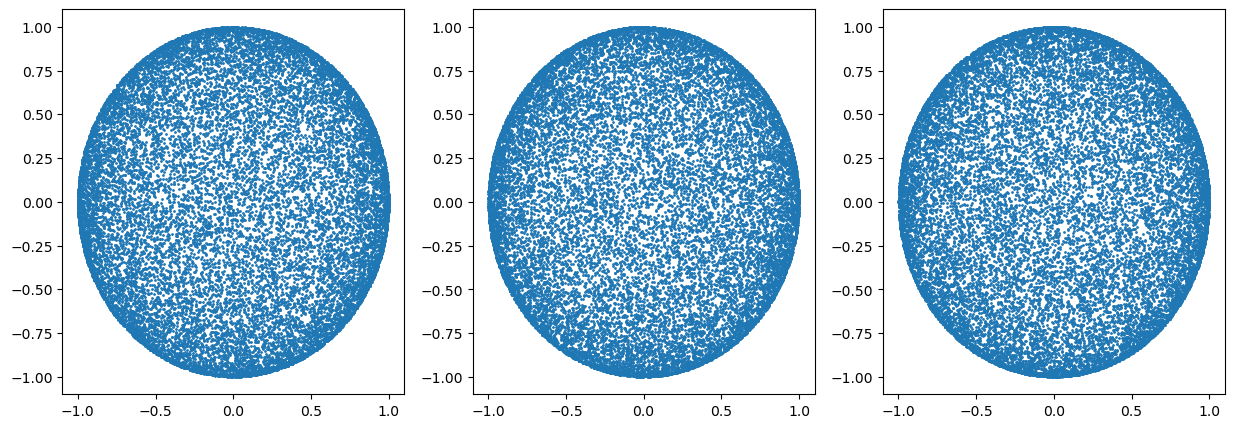

In [12]:
def random_direction(number=None):
    if number is None:
        number=1
    phi=np.random.rand(number)*2.*np.pi
    cos_theta=2.*np.random.rand(number)-np.ones(number)
    sin_theta= np.sqrt(1-cos_theta**2)
    return((np.array([sin_theta*np.cos(phi),sin_theta*np.sin(phi),cos_theta])).transpose())
    
def random_directions_test(number):
    n=random_direction(number=number)
    fig = plt.figure(figsize=(15,5))
    ax1 = plt.subplot(1,3,1)
    ax1.scatter(n[:,0],n[:,1],1)
    ax2 = plt.subplot(1,3,2)
    ax2.scatter(n[:,0],n[:,2],1)
    ax3 = plt.subplot(1,3,3)
    ax3.scatter(n[:,1],n[:,2],1)
    fig.savefig('random_directions.pdf')
    plt.show()
random_directions_test_2(20000)

Now test your code by running `random_direction_test()`. It should produce a figure that looks like this:

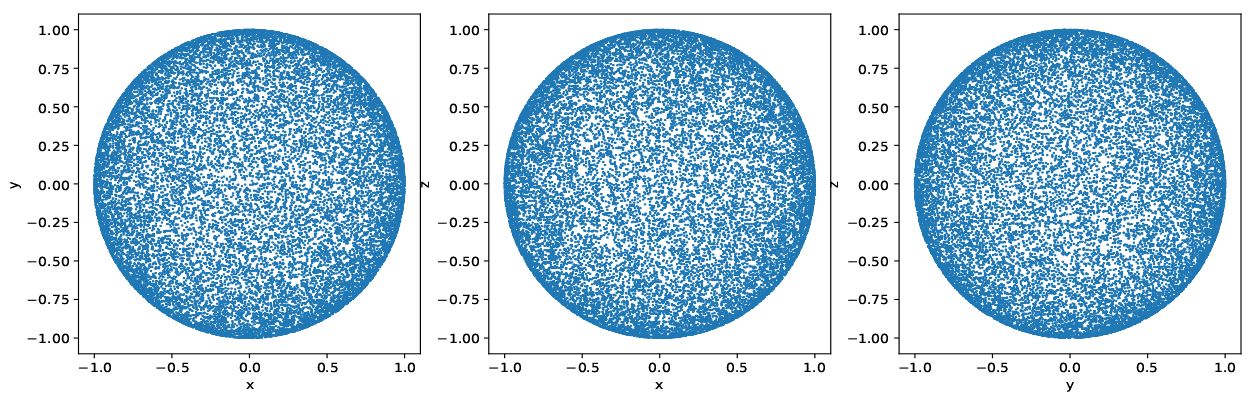

If your output does not look like the figure above, think about why __you cannot__ simply solve this problem by drawing three uniform random numbers for $x$, $y$, and $z$ to construct a vector $\mathbf{n}=(x,y,z)$.

To do this right, we want to determine both $\phi$ and $\theta$ in spherical coordinates, where $\theta$ is the angle measured from the z-axis. Our function will have to return randomly oriented, normalized 3-vectors. Start with $\phi$, then move on to $\theta$.

__Hint__: Working out $\theta$ isn't quite as easy as it might sound: Think about how $\theta$ is distributed for a random sample of points on a sphere. Before proceeding, ask yourself how likely you are to find a point to be located at the poles vs. the equator. Based on that, decide whether you want to determine $\theta$ or $\cos{(\theta)}$ first. Take a look at the image from <a href="http://mathworld.wolfram.com/SpherePointPicking.html">Wolfram.com</a> showing s
amples of randomly placed points on a sphere and see where they fall with respect to the poles and the equator:

![sphere](https://mathworld.wolfram.com/images/eps-svg/SphericalDistribution_900.png)

This is where the nature of Monte Carlo comes in: We need to find a (normalized) probability distribution for $\theta$, draw a random number between 0 and 1, and determine the value of $\theta$ that corresponds to that probability. To make progress, consider the area of a sphere for angles between 0 and $\theta$:

$$
A(\leq \theta)=2\pi \int_{0}^{\theta}d\theta' \sin{(\theta)}
$$

which is a fraction of $f=A/4\pi$ of the entire sphere. The probability that a randomly placed point will land in that area is thus

$$
P(\leq \theta)=\frac{A(\leq \theta)}{4\pi}
$$

Your job now is to invert this to find a measure of $\theta$, given some value for $P$ between 0 and 1.

You can find working code in the solutions in Section <a href="#solutions2">7.2</a>

### 2.1.2 Drawing Seed Photon Energies<a id="seedphotons"></a> <a href="#TOC">(Back to TOC)</a>

We will need to define a function that returns seed photon energies randomly drawn from the photon energy distribution. For now, we will consider only mono-energetic photons, so this is a delta function,

$$
    f(\nu)=\delta(\nu-\nu_{0})
$$

but later we will replace it with a Planck function.

In [13]:
#
# Velocity function that draws a single energy value from the seed photon energy
# distribtion. We will use a delta function in v for our first simple example, 
# but a in more realistic simulation, you would want to use a Planck function.
#

def f_of_hnu_mono(mc_parms,number=None):
    """Returns randomly drawn velocity from distribution function
    
    Args:
        mc_parms (dictionary): Monte-Carlo parameters
    
    Parameters:
        number (integer): Number of photon energies to generate

    Returns:
        numpy array: seed photon energies drawn from photon distribution
    """
    if number is None:
        number=1
    return(np.ones(number)*mc_parms['kt_seeds'])

### 2.1.3 Determining the Photon Location  <a href="#TOC">(Back to TOC)</a>

Generally, we might be interested in simulating photons emitted at different locations. However, since are a approximating the corona as a semi-infinite slab, we can start all photons at the same location, the origin, so this function returns a position vector of

$$
    \mathbf{x}_{0}=\left(\begin{array}{c}0\\0\\0\end{array}\right)
$$

In [14]:
def photon_origin(number=None):
    """Returns emission location of a photon
    """
    if number is None:
        number=1
    return(np.zeros([number,3]))

### 2.1.4 Drawing Seed Photons <a href="#TOC">(Back to TOC)</a>

Now we can generate our population of seed photons (energies and directions). We want to generate four-momentum vectors for these photons that we can then process repeated, using our Thomson scattering machinery below. For a photon energy $h\nu$ and propagation unit-vector $\mathbf{n}$, the four-momentum is

$$
    P^{\mu}=\frac{h\nu}{c}\left(\begin{array}{c}1\\n_{x}\\n_{y}\\n_{z}\end{array}\right)
$$

and we can generate $h\nu$ from `f_of_hnu_mono()` and $\mathbf{n}$ from `random_direction()`.

__Note__: In our example, we only care about up-going photons, so we flip the z-component of the velocity if it's negative.

In [15]:
def draw_seed_photons(mc_parms,number=None):
    """Returns a single seed photon
    
    Args:
        mc_parms (dictionary): MC parameters
    
    Parameters:
        number (integer): number of photons to return
        
    Returns:
        (number x 4)numpy array: Photon momentum 4-vectors
        (number x 3)numpy array: Initial photon positions
    """

    if number is None:
        number=1
    x_seed=photon_origin(number=number)
    n_seed=random_direction(number=number)
    hnu=mc_parms['hnu_dist'](mc_parms,number=number)
    p_seed=(np.array([hnu,hnu*n_seed[:,0],hnu*n_seed[:,1],hnu*np.abs(n_seed[:,2])])).transpose()/c_light
    return(p_seed,x_seed)

## 2.2 Determining Whether and Where Photons Scatter<a id="singlescatter"></a> <a href="#TOC">(Back to TOC)</a>

Now that we have generated a photon, we want to know whether and where it scatters along its path through the corona. Since we know the  We need to write a function that determines the path

Remember that we will want to keep track of our photons after several scatterings, so we will call this function repeatedly. In this function, we will have to determine whether a photon
* is actually scattering with the slab
* leaves the slab (thus contributing to the spectrum)
* or is re-absorved by hitting the optically thick disk

If a photon __is__ scattered, we will want to know the direction and new energy of the photon after the scattering event. So our function should take as input: 
* The position of the photon at the previous scattering $\mathbf{x}$
* The four-momentum of the photon after the previous scattering $\mathbf{P}_{\rm in}$
* The number density of electrons $n$
* The height of the corona $H$
* The scattering cross section $\sigma$

The last three are conveniently already stored in our dictionary `mc_parms`.

The output of our function should be the scattered photon's new four-momentum $\mathbf{P}_{\rm out}$, which encodes its new direction and energy. The code should also update the position of photon and pass it back.

__Note__: Because we are approximating the corona as a semi-infinite slab and we are assuming axi-symmetry about the vertical $z$ axis, we _really_ only care about the $z$-position.

### 2.2.1 How Far Does the Photon Travel Before Scattering? <a href="#TOC">(Back to TOC)</a>

The most important thing here will be to figure out how far the photon travels before it scatters. Then we decide what happens next in section 2.2.2.

__A quick primer on scattering radiative transfer:__ 

If you have some understanding of radiative transfer, feel free to <a href="#tag1">move on beyond this short explanation</a>.

Neglecting any sources of photons, for an intensity $I$ of photons traveling through a medium with particle density $n$, each of which has an interaction cross section $\sigma$, the radiative transfer equation is

$$
    \frac{dI}{d\tau}=-I
$$

where the optical depth along the ray of photons is defined as

$$
    d\tau\equiv n \sigma ds \ \ \ \ \ \ \ \ \ \ \ \ {\rm and} \ \ \ \ \ \ \ \ \ \ \ \ \ \tau=\int_{0}^{s} n \sigma ds
$$

In our simple model of the corona with uniform density

$$
\tau=n\sigma s
$$

The well-known solution to the radiative transfer equation is

$$
    I(\tau)=I_0 e^{-\tau}
$$

So after traveling one optical depth, only $e^{-\tau}$ photons are left in the beam, the rest have interacted. In our case, that means they scattered. Based on our discussion about Monte-Carlo simulations, our task at hand is to determine the PDF for photons to scatter within an optical depth $\tau$, that is, for a given $\tau$, what is the probability $P(\leq \tau)$ that a photon scatters at optical $\tau$ or less?

Once you know $P(\leq \tau)$, we can invert this function to determine the optical depth to which a photon traveled before scattering, give a random value for $P$, that is, we want to know

$$
    \tau(P) = ...
$$
<a id="tag1"></a>


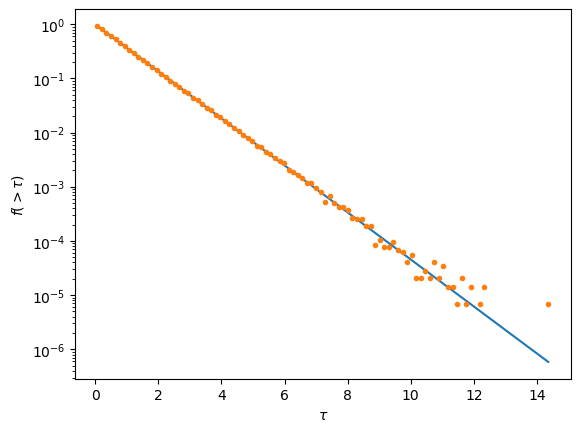

In [16]:
def tau_of_scatter():
    """Calculates optical depth a photon traveled to before interacting, given probability
    
    Args:
        None
    
    Returns:
        real: Optical depth as function of P

    """
    
    tau=-np.log(np.random.rand())
    return(tau)

#
# Now test your function. Run the following command and compare the scatter plot
# of orange points to the output your function should produce (straight blue line).
# Adjust the nphotons parameter to increase signal-to-noise at large optical
# depths.
#

def test_tau_of_scatter(nphotons):
    photon_depths=np.ones(nphotons)
    for i in range(nphotons):
        photon_depths[i]=tau_of_scatter()
    hist,ed=np.histogram(photon_depths,bins=100,density=True)
    tau_bins=0.5*(ed[1:]+ed[:-1])
    fraction=np.exp(-tau_bins)
    fig=plt.figure()
    plt.semilogy(tau_bins,fraction)
    plt.semilogy(tau_bins,hist,'.')
    plt.xlabel(r'$\tau$')
    plt.ylabel(r'$f(>\tau)$')
    plt.show()
test_tau_of_scatter(1000000)

### 2.2.2 From $\tau$ to pathlength $s$ <a href="#TOC">(Back to TOC)</a>

Now that we know the optical depth our photon traveled to before it (theoretically) scattered, we need to translate that to an actual physical distance $s$ so that we can figure our whether the photon escaped, got re-absorbed by the disk, or actually scattered.

In our uniform corona, the optical depth an the pathlength are related by

$$
    \tau=n\sigma_{\rm T}s
$$

where $\sigma_{\rm T}$ is the Thomson scattering cross section. The pathlength is, consquently

$$
    s=\frac{\tau}{n\sigma_{\rm T}}
$$

In our setup, we specify the total Height of the corona and the vertical optical depth $\tau_{\rm z}(H)=n\sigma_{\rm T}H$, so we can calculate the density as

$$
    n=\frac{\tau_{z}}{\sigma_{\rm T}H}
$$

In [17]:
#
# Calculate the distance s the photon travels after scattering
#

def distance_of_scatter(mc_parms):
    """Calculates the distance that corresponds to an optical depth tau   

    Args:
        tau (real): optical depth photon travels before scattering occurs
        mc_parsm (dictionary): MC parameters

    Returns:
        real: distance

    """

    tau=tau_of_scatter()
    electron_density=mc_parms['tau']/mc_parms['H']/sigma_t
    distance=tau/sigma_t/electron_density
    
    return(distance)

### 2.2.3 The Scattering Location <a href="#TOC">(Back to TOC)</a>

We can now determine the scattering location for this round of inverse Compto scattering by traveling a distnce `distance_of_scatter()` along the photon path. We will use that information later to determine whether the scattering actually happens: If the location is above of the corona, the photons escaped before scattering, if it is inside the disk ($z<0$), the photon was re-absorbed before scattering and disappears. If the scattering happens inside the corona, we move on to the next step in the life of a photon: the actual scattering.

In [18]:
def scatter_location(x_old,p_photon,mc_parms):
    """This function goes through the steps of a single scattering

    Args:
        x_old.   (three-element numpy array): holds the position
        p_photon (four-element numpy array): the in-coming photon four-momentum
        mc_parms (dictionary): the simulation parameters
    
    Returns:
        three-element numpy array: scattering location
    """
    
    # ...path-length:
    distance = distance_of_scatter(mc_parms)
    
    # ...in direction:
    photon_direction=p_photon[1:]/p_photon[0]
    
    # Update photon position with the new location
    x_new = x_old + distance*photon_direction
    
    return(x_new)

## 2.3 Drawing Electron Velocities from a Distribution<a id="electrons"></a> <a href="#TOC">(Back to TOC)</a>

Now that we know our photons will scatter at a particular location, we can take the next step and figure out what kind of electron it will scatter off, i.e., what the electron velocity is. We will need that velocity to Lorentz transform into the electron rest frame. 

We will assume (reasonably) that the distribution is isotropic, like our seed photons. So we have already done the first part of our distribution by defining the function `random_direction()`.

### 2.3.1 The Velocity Distribution <a href="#TOC">(Back to TOC)</a>

What is left is the distribution of $\upsilon$. For now, we will consider mono-energetic electrons:

$$
    f(\upsilon)=\delta(\upsilon - \upsilon_{0})
$$

but later we will replace it with a Maxwellian in section <a href="#maxwellian">A Maxwellian Velocity Distribution</a>.

__Note:__ Using delta functions for both $\upsilon$ and $h\nu_{0}$, we will derive the inverse Compton scattering _kernel_. Theoretically, if we want to derive the Compton-upscattered spectrum for more complicated distributions, we could convolve the kernel with those distributions to arrive at the scattered spectrum.

In [19]:
#
# Dummy velocity function that draws a random electron velocity from our 
# velocity distribtion. We will use a delta function in v for our simple example, 
# but a in more realistic simulation, you would want to use a proper random number 
# approach here.
#

def f_of_v_mono(mc_parms):
    """Returns a single randomly drawn velocity from distribution function
    
    Args:
        mc_parms (dictionary): Monte-Carlo parameters

    Returns:
        real: electron velocity drawn from distribution
    """
    
    return(mc_parms['velocity'])

### 2.3.2 Drawing Random Electron Velocities <a href="#TOC">(Back to TOC)</a>

We draw electron speeds $\upsilon$ from `mc_parms['v_dist']=f_of_v_mono`. Due to a relativistic subtlety, we cannot draw completely random velocities, so the function `draw_electron_direction()` below includes the relativistic correction for photon aberration in the electron frame.

In [20]:
def draw_electron_velocity(mc_parms,p_photon):
    v=mc_parms['v_dist'](mc_parms)
    n=draw_electron_direction(v,p_photon)
    return(v*n)

def draw_electron_direction(v,p_photon):
    phi=2.*np.pi*np.random.rand()
    cosp=np.cos(phi)
    sinp=np.sin(phi)
    cost=mu_of_p(v/c_light,np.random.rand())
    sint=np.sqrt(1 - cost**2)
    
    n_1=p_photon[1:]/p_photon[0]
    if (np.sum(np.abs(n_1[1:2])) != 0):
        n_2=np.cross(n_1,np.array([1,0,0]))
    else:
        n_2=np.cross(n_1,np.array([0,1,0]))
    n_2/=np.sqrt(np.sum(n_2**2))
    n_3=np.cross(n_1,n_2)
    
    # express new vector in old base
    n_new=(n_2*cosp+n_3*sinp)*sint + n_1*cost
    return(n_new/np.sqrt(np.sum(n_new**2)))

def mu_of_p(beta,p):
    mu=1/beta-np.sqrt(1/beta**2 + 1  - 4*p/beta + 2/beta)
    return(mu)

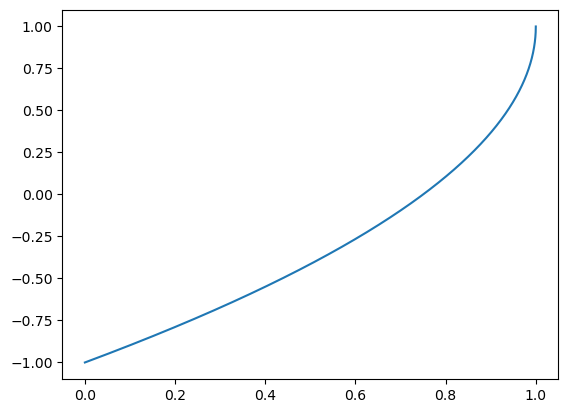

In [21]:
def mu_of_p_2(beta,p):
    mu=-1/beta-np.sqrt(1/beta**2 + 1 +4*p/beta - 2/beta)
    return(mu)

beta=0.9999
nump=10000
mu=np.zeros(nump)
p=np.linspace(0,1,nump)
for i in range(nump):
    mu[i]=mu_of_p(beta,p[i])
plt.plot(p,mu)
plt.show()

## 2.4 Lorentz Transforms<a id="Lorentz"></a> <a href="#TOC">(Back to TOC)</a>

The key to solving inverse Compton scattering is to consider it in the frame of the electron, where the electronis at rest, and where we can treat it as Thomson scattering. To that, we have to transform the photons into the frame of the electron, and that is done using the Lorentz transform of special relativity. We will define a function that performs this Lorentz transform in `lorentz_transform(p,v)` in this section.

### 2.4.1 Definition of the Lorentz Transform <a href="#TOC">(Back to TOC)</a>

Before we get started, we will need to define and use 
the Lorentz transform in an arbitrary direction. Rather
than having you go through the book-keeping of programming
it, we've added a function called lorentz_transform to do 
this for you. 

__If you are familiar with Lorentz transforms, 
you can <a href="#MCstart">skip to the next section</a>, otherwise, read on.__

We will formulate the transform in cartesian coordinates
with the so-called boost velocity $\upsilon$ (this is the 3-velocity 
of the moving frame we want to transform into). This will be 
the velocity of the electron in our observer's frame.

Recall that for a 3-velocity vector

$$ \upsilon_{i}=\left(\begin{array}{c}\upsilon_{x} \\ \upsilon_{y} \\ \upsilon_{z}\end{array}\right)$$

the Lorentz factor is defined as 

$$ \Gamma\equiv\frac{1}{\sqrt{1 - \left(\frac{\upsilon}{c}\right)^2}} $$

and we typically write the velocity in units of the speed of 
light: 

$$ \beta \equiv \frac{\upsilon}{c} $$

The corresponding four-velocity $u^{\mu}$ for a velocity vector $\mathbf{\upsilon}$ is

$$
    u^{\mu}=\Gamma\left(\begin{array}{c}1\\ \upsilon_{\rm x}\\ \upsilon_{\rm y}\\ \upsilon_{\rm z}\end{array}\right)
$$

We will transform the four-momentum of the photons we are interested in. The four-momentum of a photon with frequency $\nu$ encodes the information about its direction $\mathbf{n}$ and energy $h\nu$ and is given by

$$ P^{\mu}=\left(\begin{array}{c} p^{0} \\p^{1}\\p^{2}\\p^{3}\end{array}\right) = \frac{h\nu}{c}\left(\begin{array}{c} 1 \\ n_{\rm x} \\ n_{\rm y} \\ n_{\rm z} \end{array}\right)  = \frac{h\nu}{c}\left(\begin{array}{c} 1 \\ \sin{\theta}\cos{\phi} \\ \sin{\theta}\sin{\phi}\\ \cos{\theta}\end{array}\right)$$

The Lorentz transform is linear, so we can write it in matrix notation. Suppose the four-velocity of the frame we want to transform into is $\mathbf{\beta}$, then

$${\Lambda^{\mu}}_{\nu}(\vec{\beta})=\left(\begin{array}{cccc}\Gamma & -\Gamma\beta_{x} & -\Gamma\beta_{y} & -\Gamma\beta_{z} \\
-\Gamma\beta_{x} & 1 + \left(\Gamma - 1\right)\beta_{x}^2/\beta^2 & \left(\Gamma - 1\right)\beta_{x}\beta_{y}/\beta^2 & \left(\Gamma - 1\right)\beta_{x}\beta_{z}/\beta^2\\
-\Gamma\beta_{y} & \left(\Gamma - 1\right)\beta_{x}\beta_{y}/\beta^2 & 1+ \left(\Gamma - 1\right)\beta_{y}^2/\beta^2 & \left(\Gamma - 1\right)\beta_{y}\beta_{z}/\beta^2 \\
-\Gamma\beta_{z} & \left(\Gamma - 1\right)\beta_{x}\beta_{z}/\beta^2 & \left(\Gamma - 1\right)\beta_{y}\beta_{z}/\beta^2 & 1+ \left(\Gamma - 1\right)\beta_{z}^2/\beta^2
\end{array}\right)$$

If we know some four-vector $\mathbf{A}$ in our frame, we can then calculate the transformed four-vector $\mathbf{A}'$ in a frame moving with velocity $\mathbf{\beta}$ with respect to our frame as the matrix-vector multiplication

$$\mathbf{A}' = \Lambda\mathbf{A}$$




In [22]:
#
# Functions for general Lorentz transform
#

def lorentz_transform(p,v):
    """Returns general Lorentz transform

    Args:
        p (four-element numpy array): input four-vector
        v (three-element numpy array): the 3-velocity of the frame we want to transform into

    Returns:
        four-element numpy array: the transformed four-vector
    """

    beta=np.sqrt(np.sum(v**2))/c_light
    beta_vec=v/c_light
    gamma=1./np.sqrt(1. - beta**2)
    matrix=np.zeros((4,4))
    matrix[0,0]=gamma
    matrix[1:,0]=-gamma*beta_vec
    matrix[0,1:]=-gamma*beta_vec
    matrix[1:,1:]=(gamma-1)*np.outer(beta_vec,beta_vec)/beta**2
    for i in range(1,4):
        matrix[i,i]+=1
    return(np.dot(matrix,p))

### 2.4.2 Testing Your Lorentz Transform <a href="#TOC">(Back to TOC)</a>

Now try this out yourself by transforming some velocity vector to see whether it works. Pick a velocity where you know the resulting Lorentz transform first as a test case.

For example, we know that if a particle is moving in the same direction and with the same speed as the frame we want to transform into, it better be at rest after the transform

Then try a few others just to get a feel for how Lorentz transforms work.

In [33]:
#
# Test the above Lorentz transform on a vector of your choice for which you know the result
#

p_test=np.array([1.,0,0,0])    # this is the input four-vector
v_test=np.array([2e10,0,0])     # this is the velocity of the frame in x,y, and z

print(lorentz_transform(p_test,v_test))

#
# Feel free to explore this some more
#

[ 1.34164079 -0.89442719  0.          0.        ]


## 2.5 Thomson Scattering<a id="thomson"></a> <a href="#TOC">(Back to TOC)</a>

Now that are in the frame of the electron, we can code up Thomson Scattering of our (transformed) photons. Together with our Lorentz transform, this will be the basis for inverse Compton scattering.

### 2.5.1 Total Thomson Scattering Cross Section<a id="Sigma"></a> <a href="#TOC">(Back to TOC)</a>

We will assume Thomson scattering here for simplicity--OK for low energy photons ($h\nu \ll m_{\rm e}c^2$ in the electron's rest frame). In this case, the cross section is

$$
    \sigma_{T}= \frac{8\pi}{3}r_{\rm e}^2=\frac{8\pi e^2}{3m_{\rm e}c^2}=6.65\times 10^{-25}\,{\rm cm^{2}}
$$

We already used this when we converted optical depth to physical length. It is defined above along with the basic physical constants.

### 2.5.2 Inverting the Scattering Angle Distribution of Thomson Scattering <a href="#TOC">(Back to TOC)</a>

In inverse Compton scattering, we make our lives a lot easier by considering the scattering event in the frame of the electron. There, the problem reduces to the case of Thomson scattering: scattering of photons off of free electrons at rest. It is elastic (the photons don't lose energy) and for a scattering angle of $\theta$, it has a differential cross section of
$$
    \frac{d\sigma_{\rm T}}{d\Omega}={r_{\rm e}}^2\left[1 + \cos^2{(\theta)}\right]
$$
which integrates to a total cross section of $\sigma_{\rm T}=\frac{8\pi}{3}{r_{\rm e}}^2$

Like in the case of a randomly oriented vector, in Thomson scattering, we will want to know the distribution of photon directions _after_ scattering. This is a little harder than for an isotropic distribution, but not impossible.

We have to first find the probability distribution of $\cos{(\theta)}$ and then invert it. We can integrate the scattering cross section to find the cumulative probability to scatter into an angle smaller than $\theta$:

$$
    P(<\theta)=\frac{2\pi \int_{0}^{\theta}\sin{(\theta)} 
    d\theta \frac{d\sigma_{\rm T}}{d\Omega}}{\sigma_{\rm T}}     = 
    \frac{1}{2} - \frac{3}{8}\cos{(\theta)} - \frac{1}{8}\cos^{3}{(\theta)}
$$

So, our Monte Carlo task here is to invert this expression to find $\cos{(\theta)}$ for some probability $P$. This is a third-order equation with solutions we can look up in Mathematica, for example. Let's write this equation as

$$
    \mu^3 + 3\mu + a = 0
$$

where $\mu\equiv \cos{(\theta)}$ and $a \equiv 8P - 4$. Then the solution can be written as

$$
    \cos{(\theta)}=\mu=\frac{2^{1/3}\left(\sqrt{a^2 + 4} -a\right)^{2/3} - 2}{2^{2/3}\left(\sqrt{a^2 + 4}-a\right)^{1/3}}
$$

So, for our MC simulation, we draw a number $P$ between 0 and 1 from a uniform distribution, plug it into this equation, amd voila, we have our scattering angle. This is implemented in the function below.

We've added a demo function that demonstrates that this reporuces the angle-dependence of $d\sigma_{\rm T}/d\Omega$.

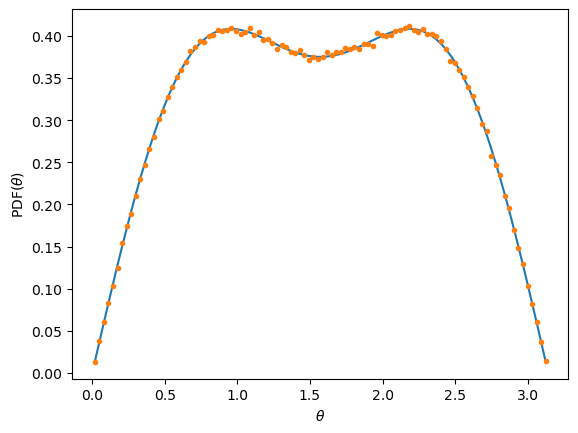

In [34]:
#
# Calculate the scattering angle for a probability between 0 and 1
#

def cos_theta_thomson(p):
    """Invert P(<\theta) to calculate cos(theta)
        
        Args:
            p (real): probability between 0 and 1
            
        Returns:
            real: scattering angle drawn from Thomson distribution
    """
    a=-4 + 8*p
    b=a**2 + 4
    return((np.power(2,1/3)*np.power(np.sqrt(b)-a,2/3)-2)/
           (np.power(2,2/3)*np.power(np.sqrt(b)-a,1/3)))

#
# OPTIONAL: If you want to test whether this works, compare to the analytic Thomson intensity distribution
# 

def thomson_demo():
    """Plot sample of scattering angles and compare to Thomson scattering
    
        Args:
            None
            
        Returns:
            None
    """
    theta=np.arccos(cos_theta_thomson(np.random.rand(1000000)))
    hist,ed=np.histogram(theta,bins=100,density=True)
    tmid=0.5*(ed[1:]+ed[:-1])
    plt.plot(tmid,3./8.*np.sin(tmid)*(1 + (np.cos(tmid))**2))
    plt.plot(tmid,hist,'.')
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'${\rm PDF}(\theta)$')
    plt.show()
    
thomson_demo()

### 2.5.3 Thomson Scattering Machinery <a href="#TOC">(Back to TOC)</a>

Now we can take an incoming photon four-vector and scatter it according to the angular distribution we just derived. The scattering angle $\theta$ is derived withe respect to the photon $\mathbf{n}$ vector (the initial propagation direction of the photon in the electron's frame). So we have to express the out-going vector relative to $\mathbf{n}$.

In [35]:
#
# Here we perform the Thomson scattering part of inverse Compton scatterin
#

#
# Here we perform the Thomson scattering part of inverse Compton scatterin
#

def thomson_scatter(p_photon):
    """This function performs Thomson scattering on a photon
    
    Args:
        p_photon (4-element numpy array): Incoming photon four-vector
        
    Returns:
        4-element numpy array: Scattered photon four-vector
    """
    
    n_1=p_photon[1:]/p_photon[0]
    if (np.sum(np.abs(n_1[1:2])) != 0):
        n_2=np.cross(n_1,np.array([1,0,0]))
    else:
        n_2=np.cross(n_1,np.array([0,1,0]))
    n_2/=np.sqrt(np.sum(n_2**2))
    n_3=np.cross(n_1,n_2)

    # scattering is uniform in phi
    phi=2.*np.pi*np.random.rand()
    cosp=np.cos(phi)
    sinp=np.sin(phi)
    
    # draw cos_theta from proper distribution
    cost=cos_theta_thomson(np.random.rand())
    sint=np.sqrt(1 - cost**2)
    
    # express new vector in old base
    n_new=(n_2*cosp+n_3*sinp)*sint + n_1*cost
    n_new/=np.sqrt(np.sum(n_new**2))
    
    # return scatterd 4-momentum vector
    return(np.array(p_photon[0]*np.array([1,n_new[0],n_new[1],n_new[2]])))

## 2.6 The Magic of Inverse Compton Scattering<a id="inversecompton"></a> <a href="#TOC">(Back to TOC)</a>

Finally, we are ready to code up the process of inverse-Compton scattering a photon four-momentum. This is where you do the three-step of inverse Compton scattering: Lorentz transform (into the electron frame), Thomson scatter, Lorentz transform (back into the observer frame). We have all the ingredients in place now. 

__To Do:__ Before moving on, answer the following question: How much energy could a photon maximally gain through a single inverse Compton-scatter off an electron with Lorentz factor $\Gamma$? You can use the function `inverse_compton_scatter()` to figure this our, or directly determine this from the Lorentz transform math in section <a href="#Lorentz">Lorentz Transforms</a>.

In [36]:
#
# Compute the new photon four-momentum after inverse Compton scattering
#
# This takes three steps:
#
# 1. Lorentz transform to electron frame
#
# 2. Randomize the photon direction, but keep its energy unchanged (Thomson scattering)
#
# 3. Lorentz transform back to the observer's frame
#

def inverse_compton_scatter(p_photon,mc_parms):
    """This function performs an iteration of inverse Compton scattering off an electron of velocity v_vec.
    
    Args:
        p_photon (four element numpy array): input photon four-momentum
        v_vec (three element numpy array): 3-velocity vector of the scattering electron
        
    Returns:
        four-element numpy array: scattered photon four-momentum in observer's frame
    """
    
    # throw the dice one more time to draw a random electron velocity
    velocity=draw_electron_velocity(mc_parms,p_photon)
    # first, transform to electron frame
    p_photon_prime=lorentz_transform(p_photon,velocity)

    # Thomson scatter
    p_out_prime=thomson_scatter(p_photon_prime)
    
    # transform back to observer frame
    return(lorentz_transform(p_out_prime,-velocity))

# 3 Are You Ready to Monte-Carlo?<a id="MC"></a> <a href="#TOC">(Back to TOC)</a>

_Fun fact: Monte-Carlo is one of only a hand full of city names that can be used as a verb._

Now that we have the machinery in place to compute a single scattering event, we can repeat it as many times as we need for each photon, and repeat it for lots of photons. This is mostly a book-keeping exercise.

We want our function to generate output for $N_{\rm photons} \gg 1$ photons. It should ouput a list of scattered photon energies and their original seed photon energies so that we can compute the Comtpon-y parameter.

The simulation paramers are all set in `mc_parms`.

## 3.1 The Monte-Carlo Code<a id="mc_code"><a/> <a href="#TOC">(Back to TOC)</a>
    
Here is the step-by-step execution of the modules from section <a href="#toolbox">Toolbox: Physics Modules to Build an ICMC Code</a>. It starts by generating the seed photon distribution using the function `draw_seed_photons()`. Then it goes through the steps of (repeated) inverse Compton scatterings for each photons. It checks whether a photon scatters using the function `scatter_location()`, and if it does, it runs the function `inverse_compton_scatter()`. It tabulates and returns the energies of all photons escaping the corona.

In [54]:
def monte_carlo(mc_parms):
    """Perform a simple Monte-Carlo simulation

    Args:
       mc_parms (dictionary): Monte-Calro parameters
    
    Returns:
        numpy array: List of escaped photon energies
        numpy array: Lost of seed energies of all escaping photons
    """
    
    # arrays to store initial and final photon energies
    hnu_seed=np.zeros(mc_parms['n_photons'])
    hnu_scattered=hnu_seed.copy()

    # draw our seed-photon population. Much faster to do this once for all photons
    p_photons,x_photons=draw_seed_photons(mc_parms,number=mc_parms['n_photons'])
   
    # run the scattering code n_photons times
    for p_photon,x_photon,i in zip(p_photons,x_photons,range(mc_parms['n_photons'])):
        # initial photon four-momentum
        # store seed photon energy for future use (calculating Compton-y parameter)
        hnu_seed[i]=p_photon[0]*c_light

        # keep scattering until absorbed or escaped
        scattered=True
        while (scattered):
            # find next scattering location
            x_photon = scatter_location(x_photon,p_photon,mc_parms)
            # if it's inside the corona, perform inverse Compton scatter
            if (x_photon[2]>=0 and x_photon[2]<=mc_parms['H']):
                p_photon=inverse_compton_scatter(p_photon,mc_parms)
            else:
                scattered=False
                if (x_photon[2]<=0):
                    p_photon*=0

        # store the outgoing photon energy in the array
        hnu_scattered[i]=p_photon[0]*c_light

    # only return escaped photons and their seed energy
    return(hnu_scattered[hnu_scattered > 0],hnu_seed[hnu_scattered > 0])

## 3.2 A Wrapper to Run and Plot Simulations<a id="plot"></a> <a href="#TOC">(Back to TOC)</a>

The best way to visualize the output of our simulation is to plot a histogram of the photon energies, in other words, __the spectrum__ of the photons up-scattered by the corona. We write a little wrapper to do that. Rather than calling `monte_carlo()`, use this function to run a simulation and plot the output.

In [77]:
def plot_mc(mc_parms,bins=None,xlims=None,filename=None):
    """Run an MC simulation and plot a histogram of the output. Saves a pdf of the plot
    
    Args:
        mc_parms (dictionary): Monte-Carlo parameters
    
    Paramters:
        bins (numpy array): Optional spectral bins
        xlims (2-element list, real): plot-limits
    
    Returns:
        numpy array: The energies of all photons escaping the corona
        numpy array: The seed-energies of the escaping photons
    """
    
    global figure_counter
    
    # Now run simulation and normalize all outgoing photon energies 
    # so we can investigate energy gains and losses
    hnu_scattered,hnu_seeds=np.array(monte_carlo(mc_parms))/mc_parms['kt_seeds'] 
    
    if (xlims is None):
        xlims=[hnu_scattered.min(),hnu_scattered.max()]    
    if (bins is None):
        bins=np.logspace(np.log10(xlims[0]),np.log10(xlims[1]),num=100)
    else:
        bins=np.logspace(np.log10(xlims[0]),np.log10(xlims[1]),num=bins)
    if (filename is None):
        filename='inverse_compton_MC_{0:d}.pdf'.format(figure_counter)

    fig=plt.figure()
    plt.hist(hnu_scattered,bins=bins,log=True,
             label=r'$\tau=${:4.1f}'.format(mc_parms['tau']))
    plt.xscale('log')
    plt.xlim(xlims[0],xlims[1])
    plt.xlabel(r'$h\nu/h\nu_{0}$',fontsize=20)
    plt.ylabel(r'$N(h\nu)$',fontsize=20)
    plt.legend()
    fig.savefig(filename,dpi=300)
    figure_counter+=1
    plt.show()
    print('Fraction of escaping photons: {0:5.3e}\n'.format(hnu_scattered.size/mc_parms['n_photons']))
    print('Compton y parameter: {0:5.3e}\n'.format(compton_y(hnu_seeds,hnu_scattered)))
    return(hnu_scattered,hnu_seeds)

# 4. Tutotial: Exploration of Your MC Code<a id="execute"></a> <a href="#TOC">(Back to TOC)</a>

Let's explore what inverse Compton scattering does to mono-energetic photons. We will go through a canned example, and then you can explore how the works for different parameters. So: Run the code immediately below. Then explore the following questions:
* What does the spectrum look like? 
* Identify the population of scattered photons vs. unscattered photons.
* In light of your answer to the __To Do__ question in section <a href="#inversecompton">The Magic of Inverse Compton Scattering</a> can you identify any photons that were scattered more than once? How would you know? (You could, of course, modify the code to keep track of the number of scatterings for each photon.)

__Note__: For large optical depths and large n_photons, the run-time can become very long. You may need to adjust n_photons accordingly so you don't have to wait too long.

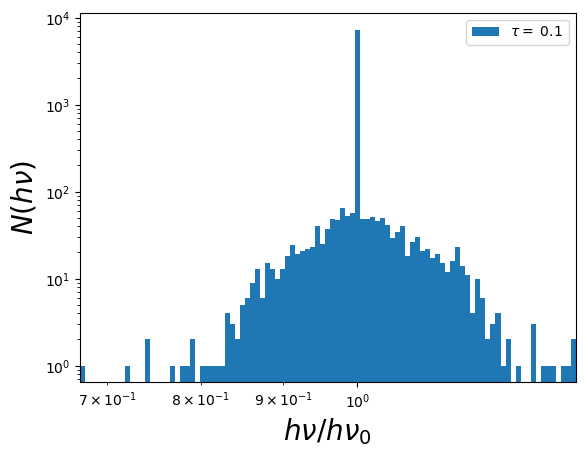

Fraction of escaping photons: 8.575e-01

Compton y parameter: 1.841e-03

1.0018406688434622 1.3648997721767113


In [78]:
#
# Run an example of a Monte Carlo simulation for optical depth 0.1
#

mc_parms={'n_photons':10000,         # start somewhat small and go up
          'kt_seeds':1.6e-9,         # 1 keV input photons
          'H':1e7,                   # say H ~ R, and R ~ 100 R_g ~ 3e7 cm
          'velocity':2.985e9,            # 10% speed of light--pretty hot
          'tau':0.1,                 # tau ~ 0.1: Small-ish optical depth
          'v_dist':f_of_v_mono,      # name of velocity distribution function
          'hnu_dist':f_of_hnu_mono,  # name of photon distribution function
         }
hnu_scattered,hnu_seeds=plot_mc(mc_parms,bins=100)
print(np.mean(hnu_scattered),np.max(hnu_scattered))

## 4.1 Exploring Optical Depth<a id="exploring_tau"></a> <a href="#TOC">(Back to TOC)</a>

Modify the code to run four different MC simulations for different $\tau$ in the range $[0.1,10]$. Then explore these questions:
- What happens to the scattered photon distribution as the optical depth increases? 
- What happens to the fraction of escaping photons? 
- Observe how the run-time of your simulation changes with optical depth. Why do you think this is?
- Plot how the Compton-y parameter depends on $\tau$. Can you find a simple approximation? Why do you think this is?

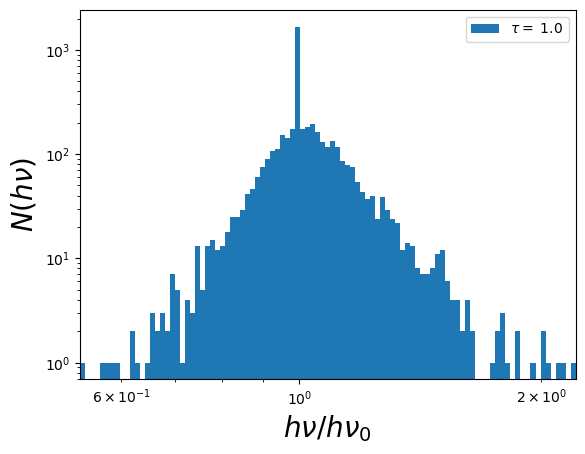

Fraction of escaping photons: 4.782e-01

Compton y parameter: 2.819e-02

1.0281943090790475 2.207371364124194


In [66]:
#
# Run an example of a Monte Carlo simulation for optical depth 0.1
#

mc_parms={'n_photons':10000,         # start somewhat small and go up
          'kt_seeds':1.6e-9,         # 1 keV input photons
          'H':1e7,                   # say H ~ R, and R ~ 100 R_g ~ 3e7 cm
          'velocity':2.985e9,            # 10% speed of light--pretty hot
          'tau':1.0,                 # tau ~ 0.1: Small-ish optical depth
          'v_dist':f_of_v_mono,      # name of velocity distribution function
          'hnu_dist':f_of_hnu_mono,  # name of photon distribution function
         }
hnu_scattered,hnu_seeds=plot_mc(mc_parms,bins=100)
print(np.mean(hnu_scattered),np.max(hnu_scattered))

In [100]:
#
# Copy and modify the code from above to explore
#


## 4.2 Exploring Number of Trials<a id="trials"></a> <a href="#TOC">(Back to TOC)</a>

Modify the number of photons (trials) in your MC simultion, using $N_{\rm photons}=[100,1000,10000,100000]$. Then explore these qeustions:

- What do you notice about the output data? 
- Think about how many photons you need to reach a certain signal-to-noise in different parts of your spectrum. What does that answer depend on?
- Observe how the run-time of your simulation changes with the number of trials.

In [101]:
#
# Copy and modify the code from above to explore
#


## 4.3 Exploring Electron Velocity (Temperature)<a id="exploring_v"><a> <a href="#TOC">(Back to TOC)</a>

Modify the velocity of the particles in your MC simulation to sample $\upsilon=[0.03,0.1,0.3,0.99]c$. Use $\tau=1$. You may need to change the bin and limit parameters of your spectrum plot to explore the shape of your spectrum. You can do this by passing the `xlim=[x1,x2]` parameter to your `plot_mc()` function or letting the function pick its own limits. Now explore these questions:
- How does the spectrum change as you change $\upsilon$?
- How does the effect of changing $\upsilon$ compare to changing $\tau$?

In [102]:
#
# Copy and modify the code from above to explore
#


## 4.4 Small $\tau$ Relativistic Test Problem<a id="test"></a> <a href="#TOC">(Back to TOC)</a>

Explore the optically thin relativistic limit that we discussed analytically: Pick a relativistic velocity (use the definition of $\Gamma$ in <a href="#Lorentz">the Lorentz transform section</a> to calculate the velocity corresponding to $\Gamma=5$ for the particles), a small optical depth, and run a simulation. Again, you will have to adjust the `xlim` parameter in `plot_mc()`. Explore these questions:
    
- What is the shape of the spectrum?
- What is the energy range?
- How is this case different from the non-relativistic case?
- How does the spectrum compare to the analytic solution? This is a great test problem for your code: A case where you know the analytic solution.

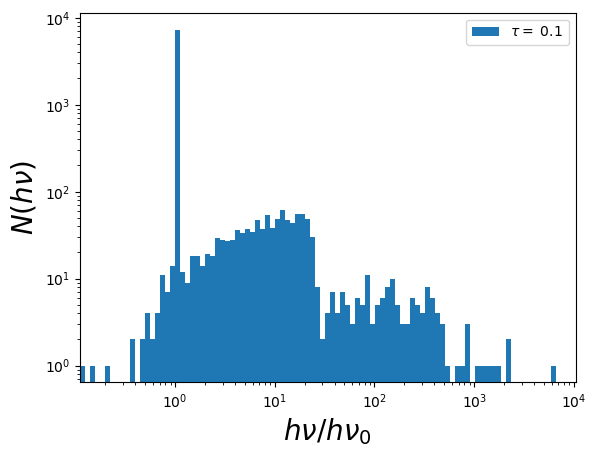

Fraction of escaping photons: 8.433e-01

Compton y parameter: 7.414e+00



In [65]:
#
# Copy and modify the code from above to explore
#

mc_parms={'n_photons':10000,         # start somewhat small and go up
          'kt_seeds':1.6e-9,         # 1 keV input photons
          'H':1e7,                   # say H ~ R, and R ~ 100 R_g ~ 3e7 cm
          'velocity':2.8e10,            # 10% speed of light--pretty hot
          'tau':0.1,                 # tau ~ 0.1: Small-ish optical depth
          'v_dist':f_of_v_mono,      # name of velocity distribution function
          'hnu_dist':f_of_hnu_mono,  # name of photon distribution function
         }
hnu_scattered,hnu_seeds=plot_mc(mc_parms)

# 5. Next Steps<a id="next"></a> <a href="#TOC">(Back to TOC)</a>

Now that you've taken the first steps into Monte-Carlo, think about how we can make our simulation more physical. What are the main simplifications we have made? Here are some questions to ponder:

1. Suppose we wanted to explore a more realistic distribution of electron energies, how would be go about that?
2. Suppose we wanted to explore a more realistic distribution of seed photon energies, how would we go about that?
3. Suppose we wanted to go beyond the accuracy of our Thomson scattering approximation, how would we go about that?
4. So far, we have only worried about the escaping photons. What do you think happens to the photons re-absorbed by the disk? How might they affect our accretion disk-corona model?


## 5.1 A Maxwellian Velocity Distribution<a id="Maxwellian"></a> <a href="#TOC">(Back to TOC)</a>

A simple extension is the implementation of a Maxwellian for the electrons. Remember that, in MC, we needed to invert the cumulative PDF to go from our randomly drawn probability (from a uniform distribution) to the variable we wanted to randomize. However, python and many other languages contain a random number generator that can draw from a Gaussian distribution. Since each velocity component in a Maxwellian is a Gaussian, we can draw three independendent velocities in $x$, $y$, and $z$ from

$$
    f(\upsilon_{i})=\frac{1}{\sqrt{2\pi\sigma^2}}e^{-m_{\rm e}{\upsilon_{i}}^2/(2kT)}
$$

In numpy, this function is called np.random.normal().

We replace our velocity distribution function `f_of_v_mono()` with `f_of_v_maxwell()` below and should be ready to go. Some questions to explore:
* How does the spectrum for a Maxwellian electron distribution differ from a mono-energetic case?
* Measure the Compton-y parameter for a fixed $\tau$ but varying $kT$ for the electrons and compare it to the equation in <a href="#comtpon-y">the section about Compton-y</a>.
* Change the optical depth between 0 and 10 and plot how $y$ depends on $\tau$. Depending on how fast/slow your computer is, you may have to reduce the number of input photons for large optical depths, because the run-time will get very long.

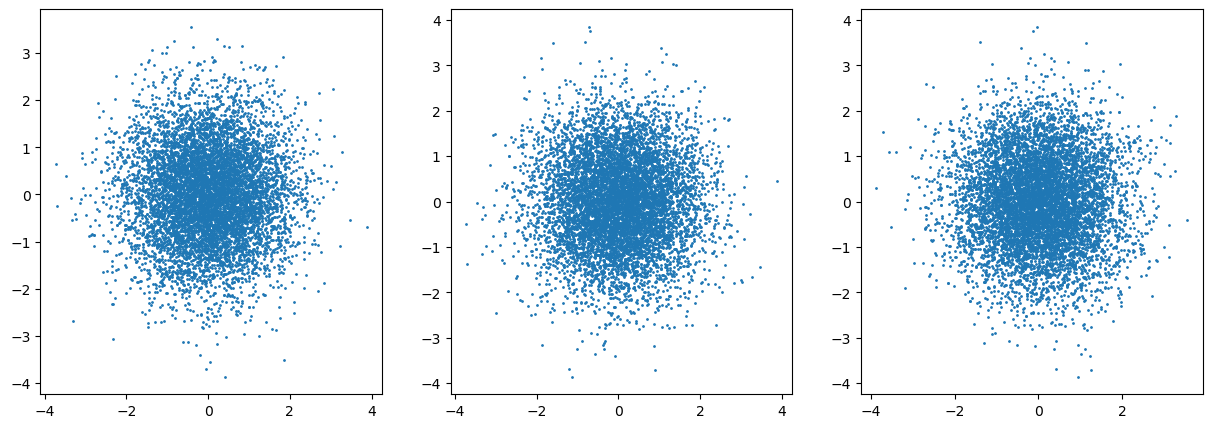

In [68]:
#
# Proper Maxwellian velocity distribution
#

def f_of_v_maxwell(mc_parms):
    """Returns a single randomly drawn velocity from distribution function
    
    Args:
        mc_parms (dictionary): Monte-Carlo parameters

    Returns:
        real: electron velocity drawn from distribution
    """
    
    # we need to draw x, y, and z velocity from a Maxwell-Boltzmann distribution'
    # and calculate the resulting speed. This is a non-relativistic Maxwelleian,
    # so me must truncate it below c.
    
    v=3e10 # needed for clipping...
    while v >= c_light:
        v=np.sqrt(mc_parms['kt_electron']/(m_electron))*np.sqrt(np.sum((np.random.normal(0,1,3))**2))
    
    return(v)

v=np.random.normal(0,1,[8000,3])
vx=v[:,0]
vy=v[:,1]
vz=v[:,2]

fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(1,3,1)
ax1.scatter(v[:,0],v[:,1],1)
ax2 = plt.subplot(1,3,2)
ax2.scatter(v[:,0],v[:,2],1)
ax3 = plt.subplot(1,3,3)
ax3.scatter(v[:,1],v[:,2],1)
fig.savefig('random_directions.pdf')
plt.show()


In [69]:
#
# For comparison, let's define a Maxwellian
#

def maxwellian(v,kT):
    """Calculate a non-relativistic Maxwellian
    
    Args:
        v (real): Velocity
        kT (real): temperature in energy units
    
    Returns:
        value of the Maxwellian at v
    """    
    return(v**2*np.sqrt(2/np.pi*(m_electron/kT)**3)*np.exp(-(m_electron*v**2/(2*kT))))

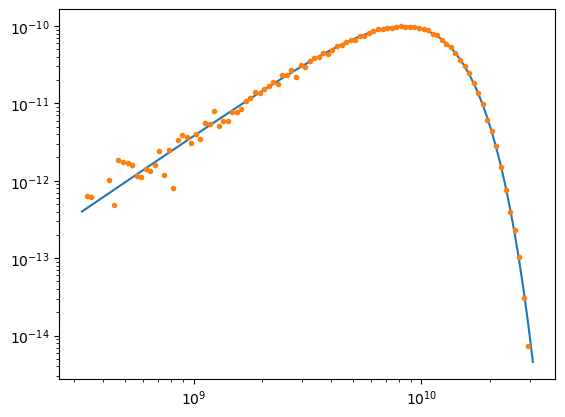

In [70]:
#
# Let's test our distribution against a true Maxwellian
#

# Let's make mc_parms consistent
def maxwell_demo():
    mc_parms['kt_electron']=3.2e-8 # 20 keV
    mc_parms['velocity']=np.sqrt(mc_parms['kt_electron']/(m_electron)) # thermal speed
    mc_parms['v_dist']=f_of_v_maxwell # this will be our new MC distribution

    # generate a random sample of velocities
    n_electrons=100000
    v=np.zeros(n_electrons)
    for i in range(n_electrons):
        v[i]=f_of_v_maxwell(mc_parms)

    # generate a histogram
    nvbins=100 # how many bins do we want?
    plot_bins=np.logspace(8.5,10.5,nvbins+1) # bins for histogram
    plot_v=np.sqrt(plot_bins[1:]*plot_bins[:-1]) # geometric mean for bin centers
    v_dist,edges=np.histogram(v,bins=plot_bins,density=True)

    # compare this to a true Maxwellian
    maxdist=maxwellian(plot_v,mc_parms['kt_electron'])
    plt.loglog(plot_v,maxdist)
    plt.loglog(plot_v,v_dist,'.')
    plt.xscale('log')
    plt.show()
    
maxwell_demo()

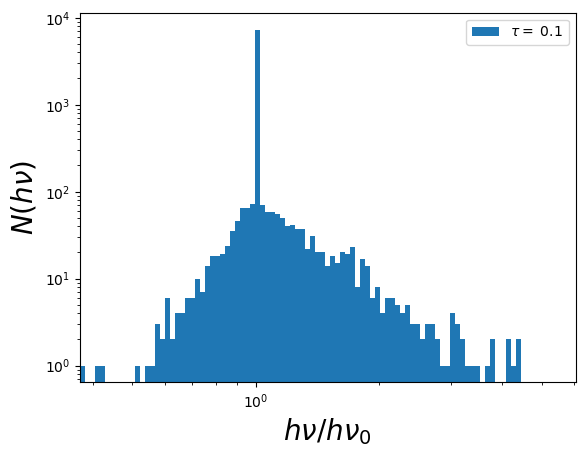

Fraction of escaping photons: 8.518e-01

Compton y parameter: 3.330e-02



In [71]:
#
# Looking good?
#
# Now run an exaple Monte Carlo simulation with a Maxwellian electron
# distribution.
#

mc_parms={'n_photons':10000,            # start somewhat small and go up
          'kt_seeds':1.6e-9,            # 1 keV input photons
          'H':1e7,                      # say H ~ R, and R ~ 100 R_g ~ 3e7 cm
          'velocity':3e9,               # 10% speed of light--pretty hot
          'tau':0.1,                    # tau ~ 0.1: Small-ish optical depth
          'kt_electron':3.2e-8,         # electron temperature: 20 keV
          'v_dist':f_of_v_maxwell,      # name of electron distribution function
          'hnu_dist':f_of_hnu_mono,     # name of photon distribution function
         }

# Let's make mc_parms consisten
mc_parms['velocity']=np.sqrt(mc_parms['kt_electron']/(m_electron)) # thermal speed

hnu_scattered,hnu_seeds=plot_mc(mc_parms)

In [108]:
#
# Copy the code above and modify to explore
#


## 5.2 A Planck Seed-Photon Distribution<a id="Planck"></a> <a href="#TOC">(Back to TOC)</a>

Ready to go further? Let's explore a Planck seed photon distribution. The code below sets up a numerical integral of the Planck probability density function. You can test the code and see if the output matches the input. All photon energies are in units of $h\nu_{0}$, which in this case must be interpreted as $kT$. Note that we are interested in the photon number distribution, not the energy distribution, so we have to divide $B_{\nu}$ by $h\nu$ to get the proper photon number distribution:

$$
    f(\nu)=\frac{8\pi\nu^2}{c^4}\frac{1}{e^{\frac{h\nu}{kT}}-1}
$$

Once you are happy with this, you can compile the new `f_of_hnu_planck()` function to replace our mono-energetic function `f_of_hnu_mono()` above and run some more Monte-Carlos with the new input. Some questions to explore:
* How does a Compton-up-scattered Planck spectrum differ from a true Planck spectrum?
* At what optical depths does the scattered spectrum start deviating measureably from the input Planck spectrum?
* At what electron energies does the scattered spectrum start to deviate measurably from the input Planck spectrum?
* Guess what: You could now calculate the SZ effect of Compton-scattering on the cosmic microwave background. However, the signal is very weak, so if you want to explore how a $~5$ keV galaxy cluster affects the microwave background by inverse-Compton scattering, you will have to use an artificially high optical depth. Since scattering is linear for $\tau \\ 1$, this is a plausible way to make the problem computationally more tractable.

/var/folders/z0/l82pr3xn36z85c275vvz6t5w0000gp/T/ipykernel_10073/2459380765.py:16: RuntimeWarning: overflow encountered in exp
  return x**2/(np.exp(x)-1)/norm
/var/folders/z0/l82pr3xn36z85c275vvz6t5w0000gp/T/ipykernel_10073/2459380765.py:16: RuntimeWarning: invalid value encountered in divide
  return x**2/(np.exp(x)-1)/norm


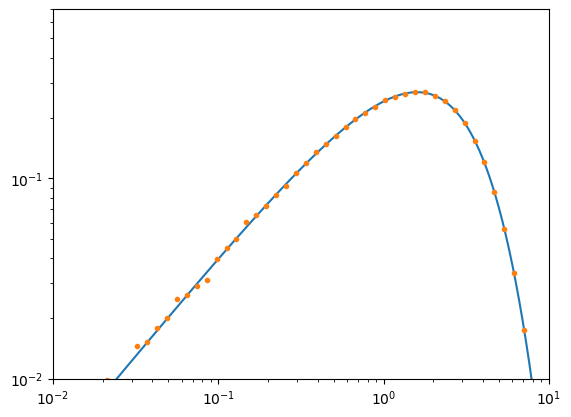

In [72]:
#
# In case you want to improve on the seed photon distribution, this will be helpful
# Note that the photon distribution function goes as nu^2, not nu^3
#

def f_planck(x):
    """Photon distribution function of a Planck distribution
    
    Args:
        x (real): photon energy e in untis of kT
        
    Returns:
        real: differential photon number dN/de at energy e
    """
    norm=2.4041138063192817
    return x**2/(np.exp(x)-1)/norm

def p_planck(hnu=None):
    """Numerical integration of cumulative planck PDF (to be inverted)
    
    Parameters:
        hnu (numpy array): bins of photon energy e in untis of kT
        
    Returns:
        numpy array: cumulative photon PDF as function of hnu
        numpy array: hnu values used for PDF
    """
    if (hnu is None):
        number=1000
        hnu=np.append(np.linspace(0,1-1./number,number),np.logspace(0,4,number))

    p=np.zeros(2*number)
    for i in range(1,2*number):
        p[i]=((quad(f_planck,0,hnu[i]))[0])
    return (p,hnu)

def hnu_of_p_planck(number=None,pdf=None,hnu=None):
    """Numerically invert Planck PDF
    
    Args:
        None
        
    Parameters:
        planck_pdf (numpy array): Previously calculated Planck PDF
        planck_hnu (numpy array): energy grid for PDF
        number (interger): Number of photon energies to generate
        
    Returns:
        numpy array: energies corresponding to p
        numpy array: cumulative PDF userd to calculate e
        numpy array: hnu grid used to calculate PDF
    """
    if number is None:
        number=1
    if (pdf is None):
        pdf,hnu=p_planck()

    e_phot=np.interp(np.random.rand(number),pdf,hnu)
    return(e_phot,pdf,hnu)

def planck_demo():
    """Demo functio to draw photons from planck distribution. Plots a 
    spectrum for a randomly drawn sample of photons, compared to the
    input Planck spectrum

    Args:
        None
        
    Returns:
        None
    """
    # First call: Populate p
    n_photons=1000000
    e,pdf,energies=hnu_of_p_planck()
    # Subsequent calls don't need to populate the PDF to save time
    e2,pdf,energies=hnu_of_p_planck(number=10,pdf=pdf,hnu=energies)
    e3,pdf,energies=hnu_of_p_planck(number=n_photons,pdf=pdf,hnu=energies)

    plot_bins=np.logspace(-2,4,101)
    plot_energies=np.sqrt(plot_bins[1:]*plot_bins[:-1])
    photon_dist,edges=np.histogram(e3,bins=plot_bins,density=True)
    plt.loglog(energies,f_planck(energies))
    plt.loglog(plot_energies,photon_dist,'.')
    plt.xscale('log')
    plt.ylim(0.01,0.7)
    plt.xlim(0.01,10)
    plt.show()
    
planck_demo()

In [73]:
#
# Looks good?
#
# Here is a new seed photon distribution to replace the one we used above.
# All you have to do is compile this function and change
# mc_parms['hnu_prob']=f_og_hnu_planck
#

def f_of_hnu_planck(mc_parms,number=None,pdf=None,energies=None):
    """Returns randomly drawn photon energy from a Planck distribution
    
    Args:
        mc_parms (dictionary): Monte-Carlo parameters

    Parameters:
        pdf (numpy array): Previously calculated Planck PDF
        hnu (numpy array): energy grid for PDF

    Returns:
        numpy array: seed photon energies drawn from photon distribution
    """
    
    if number is None:
        number=1
    if (pdf is None):
        e,pdf,energies=hnu_of_p_planck(number=number)
    else:
        e,pdf,energies=hnu_of_p_planckl(number=number,pdf=pdf,hnu=energies)        
    e*=mc_parms['kt_seeds']
    
    return(e)

/var/folders/z0/l82pr3xn36z85c275vvz6t5w0000gp/T/ipykernel_10073/2459380765.py:16: RuntimeWarning: overflow encountered in exp
  return x**2/(np.exp(x)-1)/norm


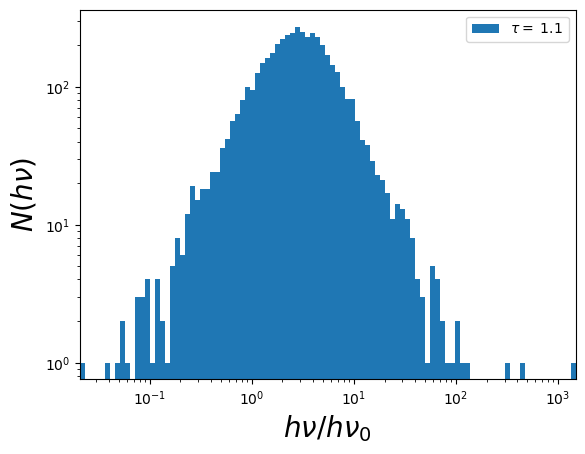

Fraction of escaping photons: 4.609e-01

Compton y parameter: 7.144e-01



In [75]:
#
# Run an example of a Monte Carlo simulation for optical depth 0.1 for
# a Planck seed photon distribution
#

mc_parms={'n_photons':10000,            # start somewhat small and go up
          'kt_seeds':1.6e-9,            # 1 keV input photons
          'H':1e7,                      # say H ~ R, and R ~ 100 R_g ~ 3e7 cm
          'tau':1.1,                    # tau ~ 0.1: Small-ish optical depth
          'kt_electron':3.2e-8,         # 20 keV
          'v_dist':f_of_v_maxwell,      # name of photon distribution function
          'hnu_dist':f_of_hnu_planck,   # name of photon distribution function
         }
hnu_scattered,hnu_seeds=plot_mc(mc_parms)

In [ ]:
#
# Copy the code above and modify to explore
#


# 5.3 Disk Reflection <a id="reflection"></a>

Looking at the spectrum in <a href="#Fig1">Figure 1</a> again, notice the third component called "Reflection". Maybe you have already thought about what happens to the photons that strike the disk that we have simply eliminated so far. Some of them will actually get reflected, through resonant or Compton scattering. 

For an object that reflects some light, we characterize the reflectivity through the so-called albedo $A(\nu)$, which is the fraction of light reflected. Suppose that our disk has a an albedo that is characterized by a function `albedo()`, how would you modify your code to include reflection?

Write an albedo function that includes a simple Gaussian iron line at $6.38\,{\rm keV}$ and run your code again.

In [ ]:
#
#
#

def albedo(hnu):
    return()

# 5.4 Covering Fraction <a id="patchy"></a>

In our simple example, the corona was assumed to cover the disk uniformly. In reality, a corona might be patchy, with some of the disk covered and others not (if you imagine the corona as being powered by magnetic energy release through localized flares in the disk, this is a pretty natural outcome).

How would you modify your code to model the corona as a locally limited region above the accretion disk? Consider a simple geometry, like a cube for each patch (which makes programming easier). For simplicity, assume that the disk is still semi-infinite, but that the corona consists of periodic cubes located at even intervals in $x$ and $y$. The key parameter to consider here is the covering fraction, that is, what fraction of the disk surface is covered with corona patches. If you want to explore this possibility, run simulations where you vary the covering fraction and observe the change in the spectrum resulting from that possibility. Really, this becomes most relevant when a proper reflection model has been implemented.

In [ ]:
#
#
#


# 6. That's It--Thanks for Playing!<a id="wrapup"></a> <a href="#TOC">(Back to TOC)</a>

There is a lot to explore here. Hopefully, you have gotten something out of it. But really, we've just scatched the surface.

Next, maybe change the disk spectrum to some other form, like a disk-blackbody. Or implement the proper Klein-Nichina cross section and the recoil term for Compton scattering of high-energy photons. The sky is the limit!

# 7. Appendix 1: Solutions<a id="appendix1"></a>  <a href="#TOC">(Back to TOC)</a>

Below are the solutions to the __To Do__ items.

## 7.1--Compton y 

We calculate the mean energy gain as
$$
    y=\langle\frac{ h\nu_{\rm post}- h\nu_{\rm pre}}{h\nu_{\rm pre}}\rangle
$$

In [ ]:
def compton_y(pre,post):
    return = np.mean((post-pre)/pre)

## 7.2 Randomized Orientation <a id="solutions2"></a>

First, we can randomize $\phi$ directly, uniformly distributed between $0$ and $2\pi$. If we draw a uniformly distributed random number for the probability $P$, we have

$$
    \phi=2\pi P
$$

For randomly placed points on a sphere (an isotropic distribution of unit vectors), we have to randomize $\cos{(\theta)}$, not $\theta$. To see this, consider the fraction $f$ of the sphere's area at angles less than $\theta$:

$$
    f(<\theta)=\frac{2\pi\int_{0}^{\theta} \sin{(\theta')}d\theta'}{4\pi}=\frac{1 - \cos{(\theta)}}{2}
$$

which is a number between zero an 1 and tells us the probability $P=f$ that a point will fall within that area. So:

$$
    \cos{(\theta)} = 2P - 1
$$

In [ ]:
def random_direction(number=None):
    """Returns randomly oriented unit vectors.

    Args: 
        None
        
    Parameters:
        number: number of random vectors to return

    Returns::
        (number,3)-element numpy array: Randomly oriented unit vectors
    """

    if number is None:
        number=1

    phi=2.*np.pi*np.random.rand(number)
    cos_phi=np.cos(phi)
    sin_phi=np.sin(phi)
    cos_theta=2.*np.random.rand(number)-1
    sin_theta=np.sqrt(1 - cos_theta**2)
    return((np.array([sin_theta*cos_phi,sin_theta*sin_phi,cos_theta])).transpose())

## 7.3 How Far Does the Photon Travel Before Scattering? 

The fraction of photons left in the initial beam after optical depth $\tau$ is $f_{\rm in}=e^{-\tau}$. But we are interested in the fraction that scattered, which is $f_{\rm out}=1-f_{\rm in}$:

$$
    P=f_{\rm out}=1 - e^{-\tau}
$$

which is the probability $P=f_{\rm out}$ that a photon scattered at optical depth $\tau$ or smaller. We invert to find the optical depth as a function of $P$:

$$
    \tau(P)=\ln{\left(\frac{1}{1-P}\right)}
$$

Since $P$ is a random number uniformely distributed between 0 and 1, we can replace $1-P$ with $P$ to get

$$
    \tau=\ln{\left(\frac{1}{P}\right)}=-\ln{(P)}
$$

In [ ]:
def tau_of_scatter():
    """Calculates optical depth a photon traveled to before interacting, given probability
    
    Args:
        None
    
    Returns:
        real: Optical depth as function of P

    """
    
    tau=-np.log(np.random.rand())
    return(tau)

## 7.4 Lorentz Transforms

We can, for example, transform the four-velocity of our boost in the new frame, where it should be at rest. As the boost-velocity, we can pick $\upsilon=c(\beta,0,0)$ for simplicity. If we transform the corresponding four-velocity

$$
    \upsilon^{\mu}=c\left( \begin{array}{c} \Gamma \\ \Gamma\beta \\ 0 \\ 0 \end{array}\right)
$$

the result must be

$$
    \upsilon^{\mu}_{1}={\Lambda^{\mu}}_{\nu}\upsilon^{\nu}_{0} = \left(\begin{array}{c}1\\0\\0\\0\end{array}\right)
$$

In [ ]:
c=3e10
beta=0.9
gamma=np.sqrt(1/(1 - beta**2))
p=c*np.array([gamma,gamma*beta,0,0])
v=c*np.array([beta,0,0])
print(lorentz_transform(p,v)/c)

## 7.5 Maximum Energy Gain in Inverse Compton Scattering

From the form of the Lorentz transform matrix, we can see that the maximum ernergy gain will occur for a photon that is initially traveling in the opposite direction of the electron and then gets scattered by $180^{\circ}$ for a boost of

$$
    h\nu_{\rm scattered}=\left[\Gamma\left(1 + \beta\right)\right]^2 h\nu_{\rm seed} = \frac{1 + \beta}{1 - \beta}h\nu_{\rm seed}
$$

For ultra-relativistic velocities, this is of order $h\nu_{\rm scattered}\approx 4\Gamma^2 h\nu_{\rm seed}$.

# 8. Appendix 2: Raw Code<a id="appendix2"></a>  <a href="#TOC">(Back to TOC)</a>

Raw, uncommented code

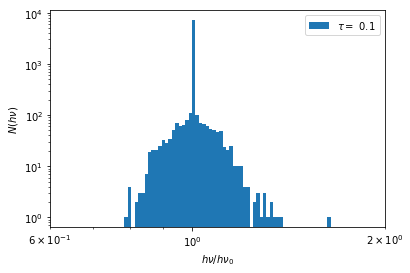

Fraction of escaping photons: 8.592e-01

Compton y parameter: 1.651e-03



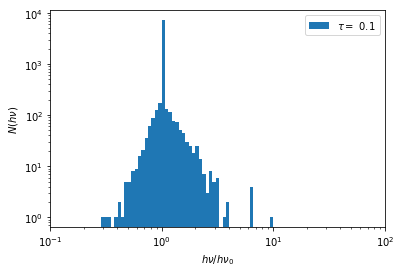

Fraction of escaping photons: 8.544e-01

Compton y parameter: 2.861e-02



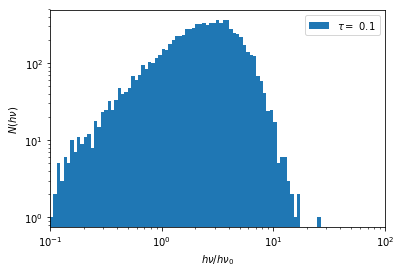

Fraction of escaping photons: 8.653e-01

Compton y parameter: 2.598e-02



In [46]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.integrate as integrate
from scipy.integrate import quad

c_light=3.e10              
m_electron=9.10938356e-28  
sigma_t=6.65e-25           
figure_counter=0           

def compton_y(pre,post):
    y = np.mean((post-pre)/pre)
    return(y)

def random_direction(number=None):
    if number is None:
        number=1
    phi=np.random.rand(number)*2.*np.pi
    cos_theta=2.*np.random.rand(number)-np.ones(number)
    sin_theta= np.sqrt(1-cos_theta**2)
    return((np.array([sin_theta*np.cos(phi),sin_theta*np.sin(phi),cos_theta])).transpose())

def f_of_hnu_mono(mc_parms,number=None):
    if number is None:
        number=1
    return(np.ones(number)*mc_parms['kt_seeds'])

def photon_origin(number=None):
    if number is None:
        number=1
    return(np.zeros([number,3]))

def draw_seed_photons(mc_parms,number=None):
    if number is None:
        number=1
    x_seed=photon_origin(number=number)
    n_seed=random_direction(number=number)
    hnu=mc_parms['hnu_dist'](mc_parms,number=number)
    p_seed=(np.array([hnu,hnu*n_seed[:,0],hnu*n_seed[:,1],hnu*np.abs(n_seed[:,2])])).transpose()/c_light
    return(p_seed,x_seed)

def tau_of_scatter():
    return(-np.log(np.random.rand()))

def distance_of_scatter(mc_parms):
    tau=tau_of_scatter()
    electron_density=mc_parms['tau']/mc_parms['H']/sigma_t
    distance=tau/sigma_t/electron_density    
    return(distance)

def scatter_location(x_old,p_photon,mc_parms):
    distance = distance_of_scatter(mc_parms)
    photon_direction=p_photon[1:]/p_photon[0]
    x_new = x_old + distance*photon_direction
    return(x_new)

def f_of_v_mono(mc_parms):
    return(mc_parms['velocity'])

def draw_electron_velocity(mc_parms):
    n=random_direction()
    v=mc_parms['v_dist'](mc_parms)
    return(v*n)

def lorentz_transform(p,v):
    beta=np.sqrt(np.sum(v**2))/c_light
    beta_vec=v/c_light
    gamma=1./np.sqrt(1. - beta**2)
    matrix=np.zeros((4,4))
    matrix[0,0]=gamma
    matrix[1:,0]=-gamma*beta_vec
    matrix[0,1:]=-gamma*beta_vec
    matrix[1:,1:]=(gamma-1)*np.outer(beta_vec,beta_vec)/beta**2
    for i in range(1,4):
        matrix[i,i]+=1
    return(np.dot(matrix,p))

def cos_theta_thomson(p):
    a=-4 + 8*p
    b=a**2 + 4
    return((np.power(2,1/3)*np.power(np.sqrt(b)-a,2/3)-2)/
           (np.power(2,2/3)*np.power(np.sqrt(b)-a,1/3)))

def thomson_scatter(p_photon):
    n_1=p_photon[1:]/p_photon[0]
    if (np.sum(np.abs(n_1[1:2])) != 0):
        n_2=np.cross(n_1,np.array([1,0,0]))
    else:
        n_2=np.cross(n_1,np.array([0,1,0]))
    n_2/=np.sqrt(np.sum(n_2**2))
    n_3=np.cross(n_1,n_2)
    phi=2.*np.pi*np.random.rand()
    cosp=np.cos(phi)
    sinp=np.sin(phi)
    cost=cos_theta_thomson(np.random.rand())
    sint=np.sqrt(1 - cost**2)
    n_new=(n_2*cosp+n_3*sinp)*sint + n_1*cost
    n_new/=np.sqrt(np.sum(n_new**2))
    return(np.array(p_photon[0]*np.array([1,n_new[0],n_new[1],n_new[2]])))

def inverse_compton_scatter(p_photon,mc_parms):
    velocity=draw_electron_velocity(mc_parms)
    p_photon_prime=lorentz_transform(p_photon,velocity)
    p_out_prime=thomson_scatter(p_photon_prime)
    return(lorentz_transform(p_out_prime,-velocity))

def monte_carlo(mc_parms):
    hnu_seed=np.zeros(mc_parms['n_photons'])
    hnu_scattered=hnu_seed.copy()
    p_photons,x_photons=draw_seed_photons(mc_parms,number=mc_parms['n_photons'])
    for p_photon,x_photon,i in zip(p_photons,x_photons,range(mc_parms['n_photons'])):
        hnu_seed[i]=p_photon[0]*c_light
        scattered=True
        while (scattered):
            x_photon = scatter_location(x_photon,p_photon,mc_parms)
            if (x_photon[2]>=0 and x_photon[2]<=mc_parms['H']):
                p_photon=inverse_compton_scatter(p_photon,mc_parms)
            else:
                scattered=False
                if (x_photon[2]<=0):
                    p_photon*=0
        hnu_scattered[i]=p_photon[0]*c_light
    return(hnu_scattered[hnu_scattered > 0],hnu_seed[hnu_scattered > 0])

def plot_mc(mc_parms,bins=None,xlims=None,filename=None):
    global figure_counter
    if (xlims is None):
        xlims=[0.1,100]    
    if (bins is None):
        bins=np.logspace(np.log10(xlims[0]),np.log10(xlims[1]),num=100)
    if (filename is None):
        filename='inverse_compton_MC_{0:d}.pdf'.format(figure_counter)
    hnu_scattered,hnu_seeds=np.array(monte_carlo(mc_parms))/mc_parms['kt_seeds'] 
    fig=plt.figure()
    plt.hist(hnu_scattered,bins=bins,log=True,
             label=r'$\tau=${:4.1f}'.format(mc_parms['tau']))
    plt.xscale('log')
    plt.xlim(xlims[0],xlims[1])
    plt.xlabel(r'$h\nu/h\nu_{0}$')
    plt.ylabel(r'$N(h\nu)$')
    plt.legend()
    fig.savefig(filename)
    figure_counter+=1
    plt.show()
    print('Fraction of escaping photons: {0:5.3e}\n'.format(hnu_scattered.size/mc_parms['n_photons']))
    print('Compton y parameter: {0:5.3e}\n'.format(compton_y(hnu_seeds,hnu_scattered)))
    return(hnu_scattered,hnu_seeds)

mc_parms={'n_photons':10000,'kt_seeds':1.6e-9,'H':1e7,'velocity':2.985e9,'tau':0.1,'v_dist':f_of_v_mono,'hnu_dist':f_of_hnu_mono}

hnu_scattered,hnu_seeds=plot_mc(mc_parms,xlims=[0.6,2])

def f_of_v_maxwell(mc_parms):
    v=3e10
    while v >= c_light:
        v=np.sqrt(mc_parms['kt_electron']/(m_electron))*np.sqrt(np.sum((np.random.normal(0,1,3))**2))
    return(v)

mc_parms={'n_photons':10000,'kt_seeds':1.6e-9,'H':1e7,'velocity':3e9,'tau':0.1,'kt_electron':3.2e-8,'v_dist':f_of_v_maxwell,'hnu_dist':f_of_hnu_mono}
mc_parms['velocity']=np.sqrt(mc_parms['kt_electron']/(m_electron))

hnu_scattered,hnu_seeds=plot_mc(mc_parms)

def f_planck(x):
    norm=2.4041138063192817
    return x**2/(np.exp(x)-1)/norm

def p_planck(hnu=None):
    if (hnu is None):
        number=1000
        hnu=np.append(np.linspace(0,1-1./number,number),np.logspace(0,4,number))

    p=np.zeros(2*number)
    for i in range(1,2*number):
        p[i]=((quad(f_planck,0,hnu[i]))[0])
    return (p,hnu)

def hnu_of_p_planck(number=None,pdf=None,hnu=None):
    if number is None:
        number=1
    if (pdf is None):
        pdf,hnu=p_planck()

    e_phot=np.interp(np.random.rand(number),pdf,hnu)
    return(e_phot,pdf,hnu)

def f_of_hnu_planck(mc_parms,number=None,pdf=None,energies=None):
    if number is None:
        number=1
    if (pdf is None):
        e,pdf,energies=hnu_of_p_planck(number=number)
    else:
        e,pdf,energies=hnu_of_p_planckl(number=number,pdf=pdf,hnu=energies)        
    e*=mc_parms['kt_seeds']    
    return(e)

mc_parms={'n_photons':10000,'kt_seeds':1.6e-9,'H':1e7,'tau':0.1,'kt_electron':3.2e-8,'v_dist':f_of_v_maxwell,'hnu_dist':f_of_hnu_planck}
hnu_scattered,hnu_seeds=plot_mc(mc_parms)